In [1]:
from field_util import Field, CartCoord

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import astropy.coordinates as coord
from astropy.coordinates.matrix_utilities import rotation_matrix
import numpy as np
from scipy import ndimage
import copy
from matplotlib.colors import LogNorm as LogNorm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import pandas as pd
import os

from matplotlib.backends.backend_pdf import PdfPages

In [2]:
cosmo = FlatLambdaCDM(H0=100* u.km / u.s / u.Mpc, Om0=0.315) # Metin original

mycoord = CartCoord(150.14205192829834, 2.224237689411875, cosmo) # Used in Cosmic Birth
x_0, y_0, z_0 = mycoord.orig_to_box(149.89, 2.07, 2.05)

ra_min = 150.06
ra_max = 150.09

dec_mean = 2.30
dec_min = 2.07
dec_max = 2.50

red_mean = 2.30
red_min = 2.05
red_max = 2.55

x_min = x_0
x_max = x_0 + 438.*u.Mpc

z_min = z_0
z_max = z_0 + 24.*u.Mpc

In [3]:
cosmo = FlatLambdaCDM(H0=100* u.km / u.s / u.Mpc, Om0=0.315) # Metin original
mycoord = CartCoord(150.14205192829834, 2.224237689411875, cosmo) # Used in Cosmic Birth

data_path = '../Data/'
plot_path = '../Plot/'

In [4]:
R_sm = 4 * u.Mpc

# CLAMATO density field
clamato_path = '../Data/CLAMATO/map_2020_v0.bin'
delta_clm = np.fromfile(clamato_path, dtype='double').reshape(68, 56, 876).transpose(2, 0, 1)
delta_clm = delta_clm[::1,::-1,::1] 
# this reversal is due to the coordinate in clamato is 
#    x - ra     y - dec
#    0 - 149.89 0 - 2.07
#    68 - 150.4 56 - 2.50  
# consistent with https://github.com/kheegan/preheating2019
x_0, y_0, z_0 = mycoord.orig_to_box(149.89, 2.07, 2.05)
CLAMATO_field = Field(x_0, y_0-34*u.Mpc, z_0, 0.5*u.Mpc, delta_clm)
res = CLAMATO_field.smooth(R_sm)


# CLAMATO galaxies
clamato_gal = '../Data/CLAMATO/list_tomo_input_2020_mod.txt'
clm_gal_list = pd.read_csv(clamato_gal, sep = '\t', header = 0)

In [15]:
# reconstruction
# delta_rec_mock = np.fromfile(data_path+"rec_field_sim/pixel_data_RUN11_2980_3_true_SNR.bin_map.bin", dtype='double').reshape(68, 56, 876).transpose(2, 0, 1)
# delta_rec_mock = delta_rec_mock[::1,::-1,::1]
import fnmatch


try:
    delta_mock_list = [np.fromfile(data_path+"rec_field_sim/"+fn, dtype='double').reshape(68, 56, 876).transpose(2, 0, 1)[::1, ::-1, ::1]
                        for fn in os.listdir(data_path+"rec_field_sim/") if fn[-3:] == 'bin']
except:
    print(fn)

delta_rec_mock = np.mean(np.array(delta_mock_list), axis = 0)
rec_field = Field(x_0, y_0-34*u.Mpc, z_0, 0.5*u.Mpc, delta_rec_mock)
# res = rec_field.smooth_tophat_fft(R_tophat)
res = rec_field.smooth(R_sm)


x0, y0, z0 = 3550*u.Mpc, -50*u.Mpc, -50*u.Mpc
dl = 2*u.Mpc

# matter
dens_m_2980 = np.load(data_path+"lores/RUN11_2980_256.00103lowres_density.npy")[:, ::-1, :]
opdelta_m_2980 = dens_m_2980 / np.mean(dens_m_2980)
opdelta_m_field = Field(x0, y0, z0, dl, opdelta_m_2980)
# res = opdelta_m_field.smooth_tophat_fft(R_tophat) # 1 + delta_m
res = opdelta_m_field.smooth(R_sm) # 1 + delta_m

# FGPA + RSD
tau_2980 = np.load(data_path+"lores/RUN11_2980_256.00103lowres_tau.npy")[:, ::-1, :]
F_2980 = np.exp(-tau_2980)
delta_F_2980 = F_2980 / np.mean(F_2980) - 1
delta_F_field = Field(x0, y0, z0, dl, delta_F_2980)
# res = delta_F_field.smooth_tophat_fft(R_tophat)
res = delta_F_field.smooth(R_sm)

In [16]:
#RA, DE, red = 149.96480, 2.15000, 2.33
#x_o, y_o, z_o = 1.0*u.Mpc, 0.0*u.Mpc, 244.5*u.Mpc
#x_n, y_n, z_n = mycoord.orig_to_box(RA, DE, red)

RA, DE, red = 150.110, 2.161, 2.298
x_o, y_o, z_o = 1.0*u.Mpc, 0.0*u.Mpc, 244.5*u.Mpc
x_n, y_n, z_n = mycoord.orig_to_box(RA, DE, red)

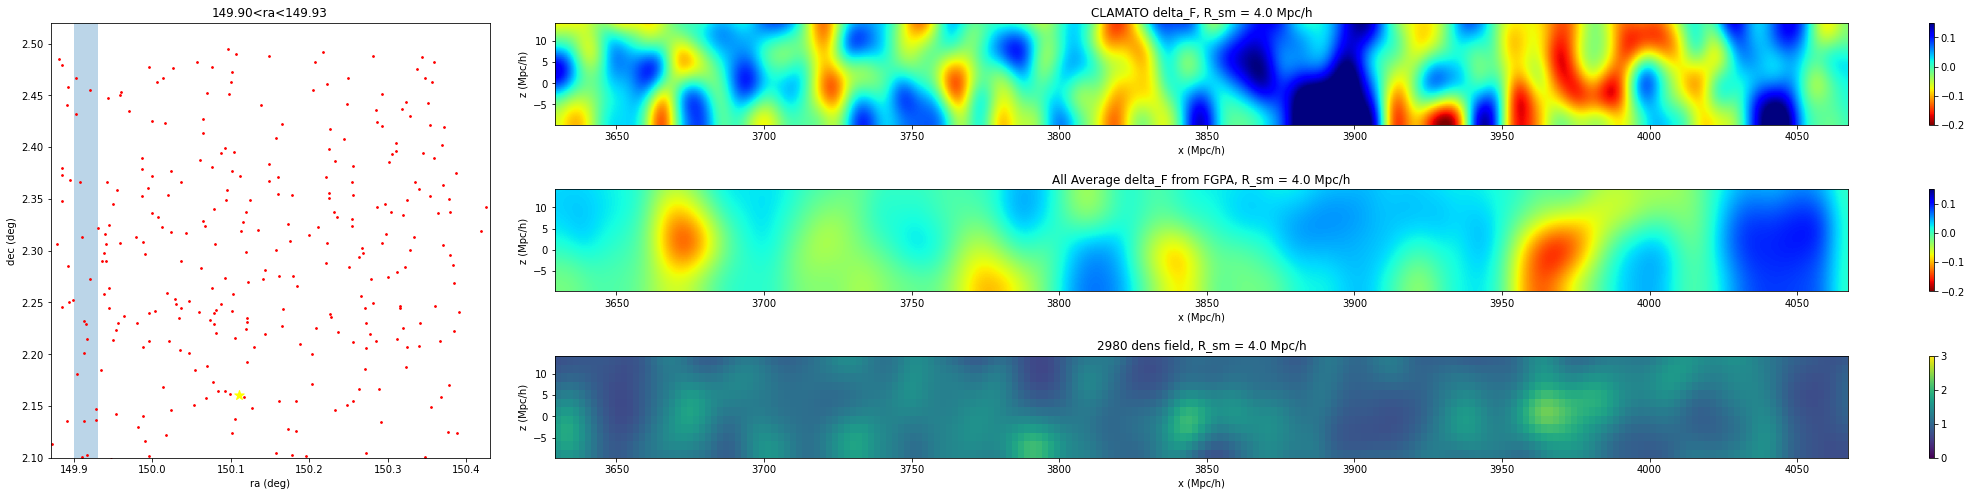

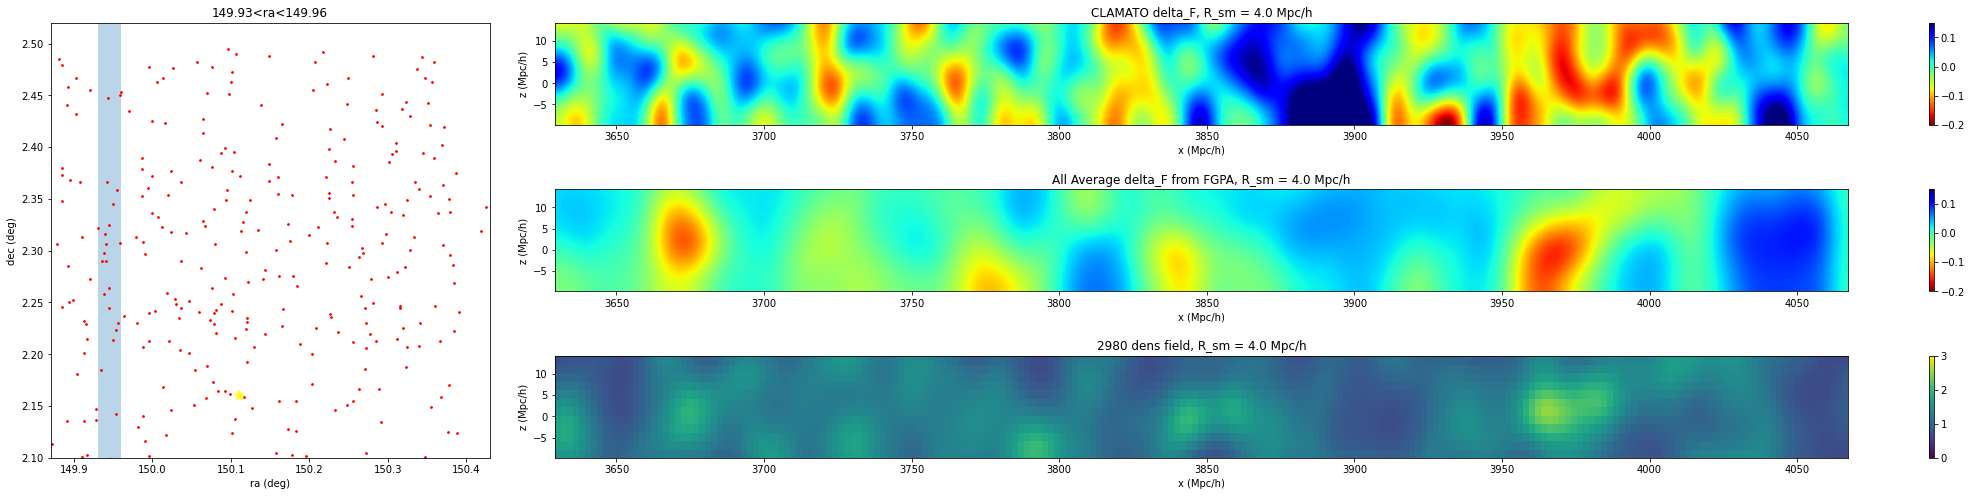

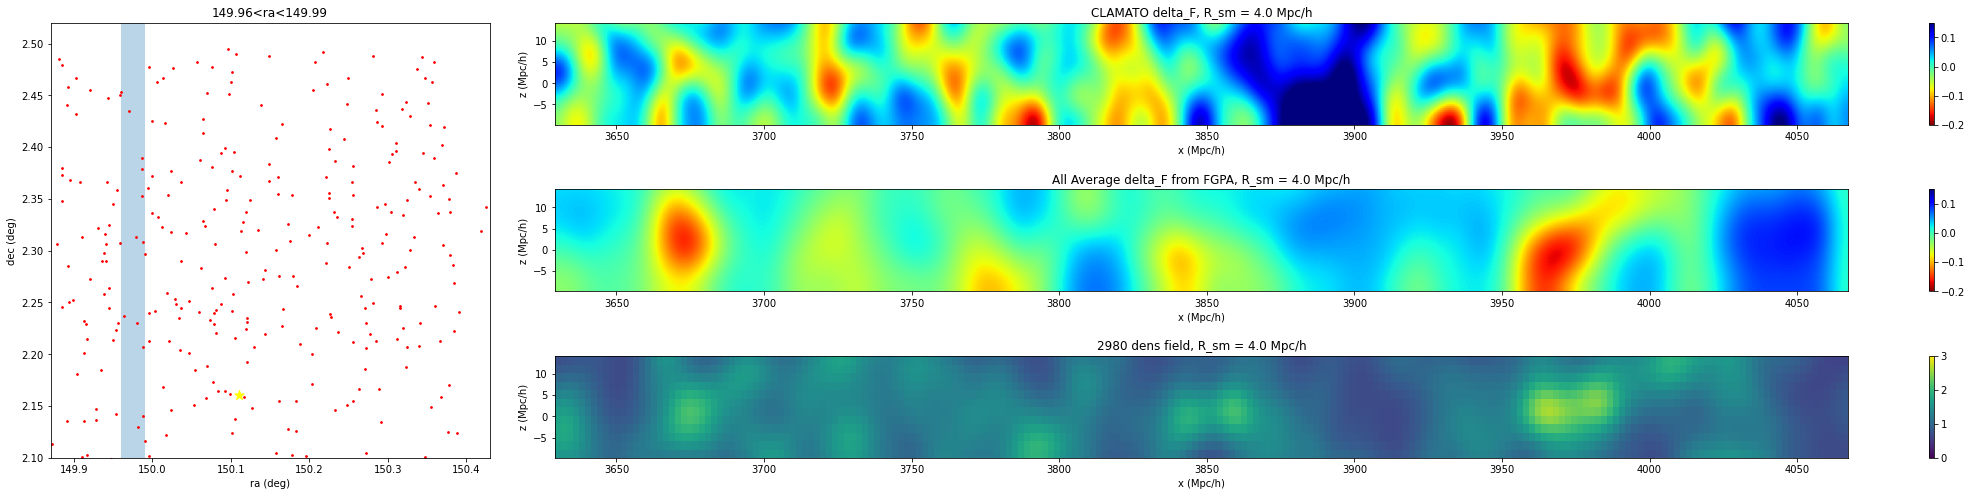

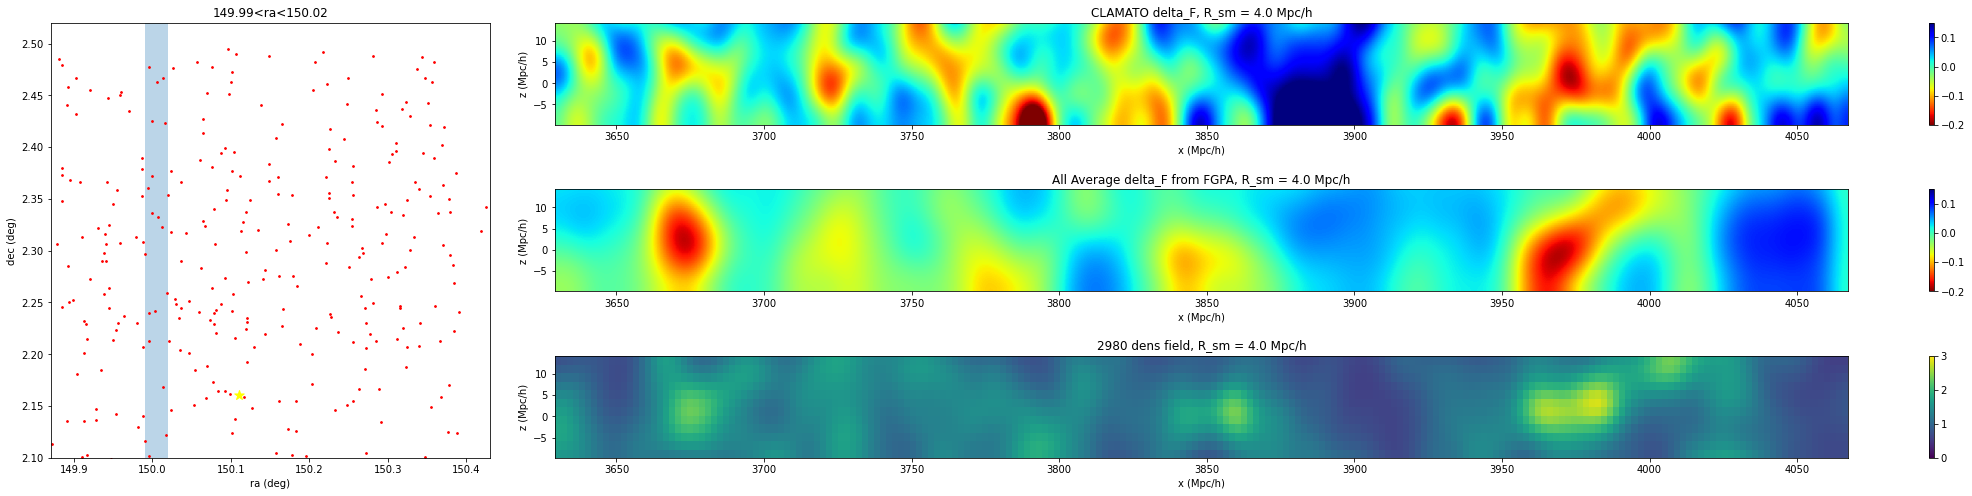

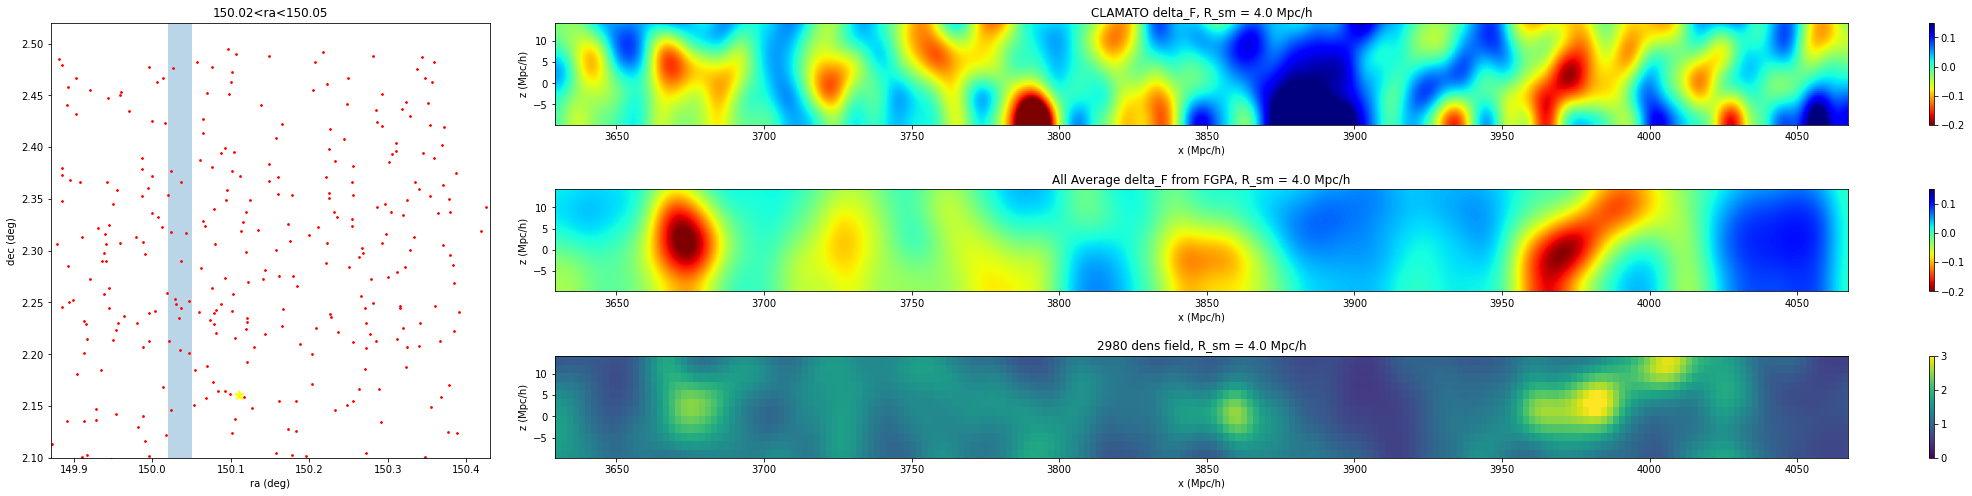

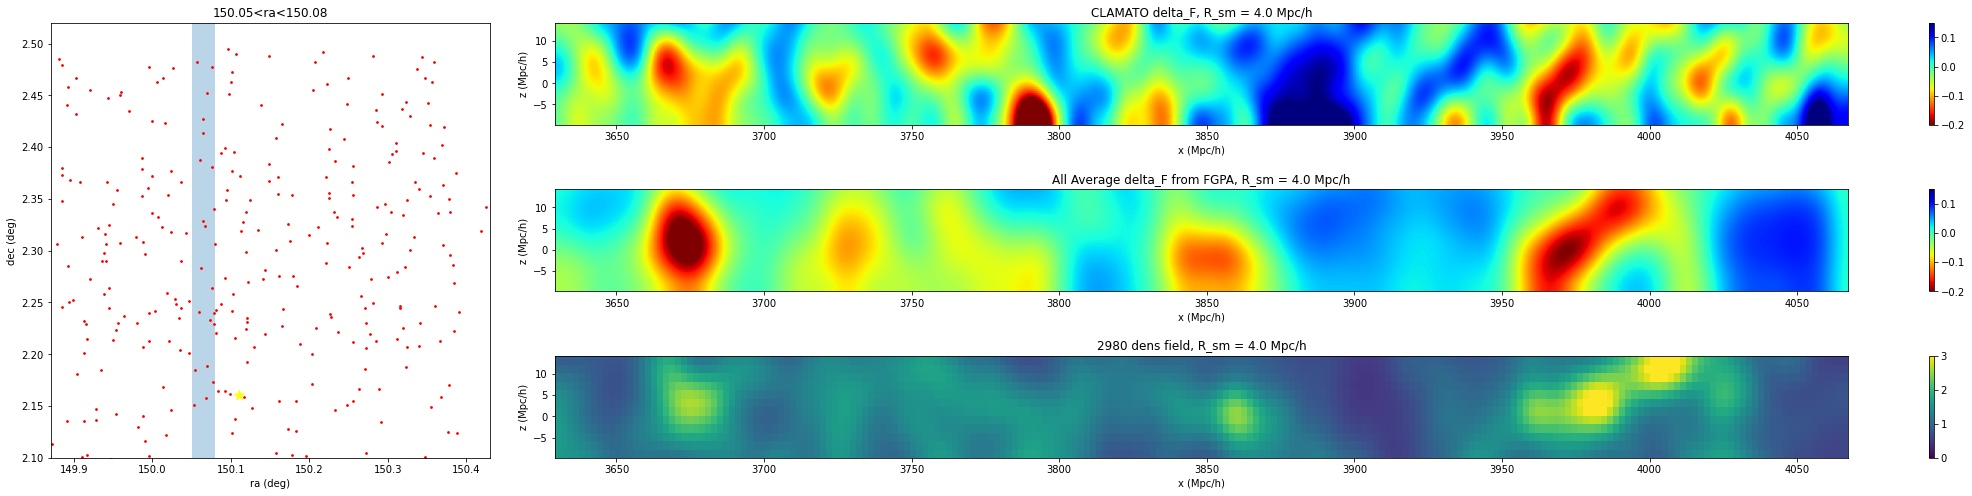

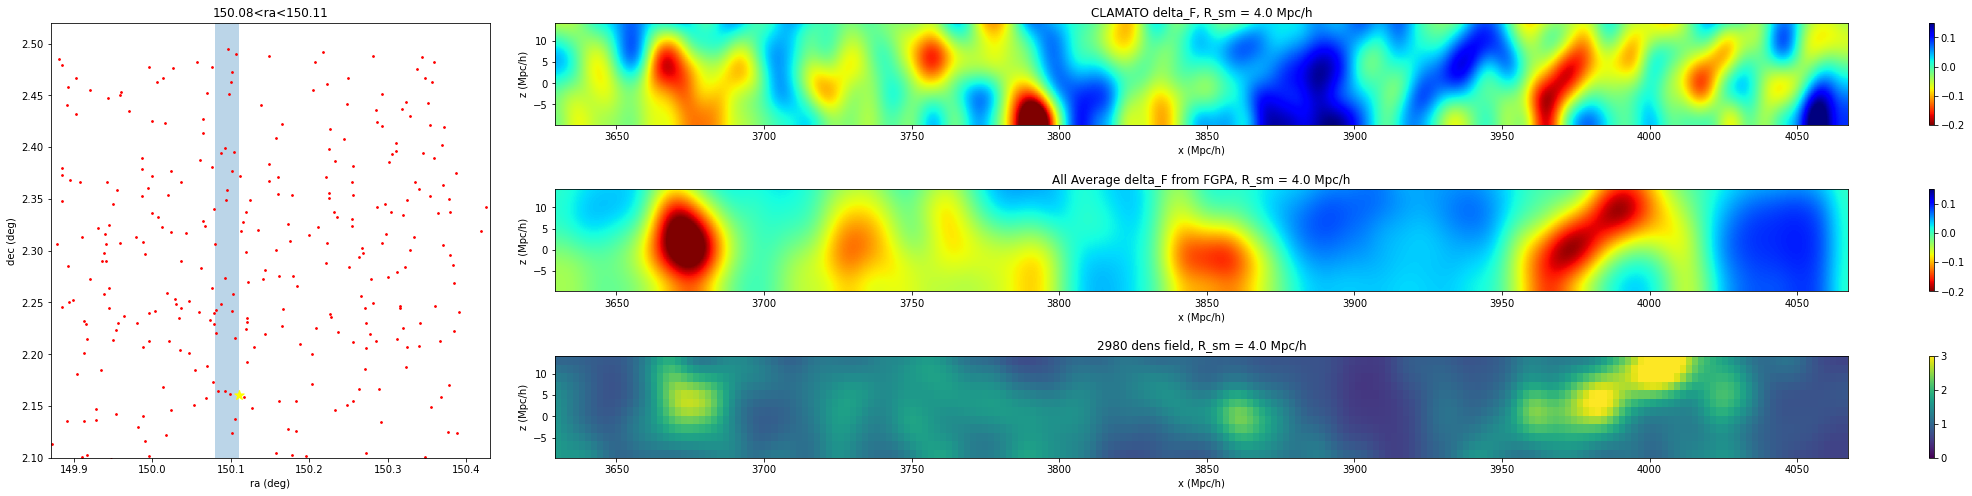

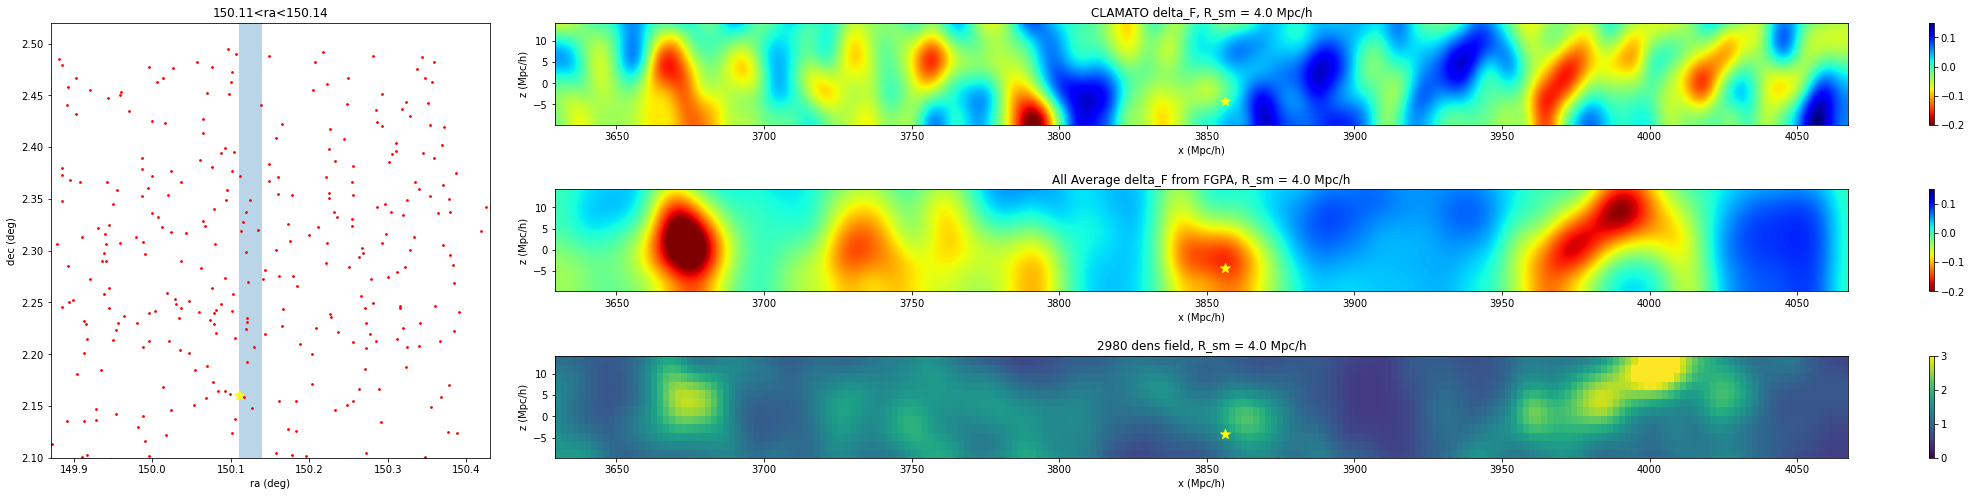

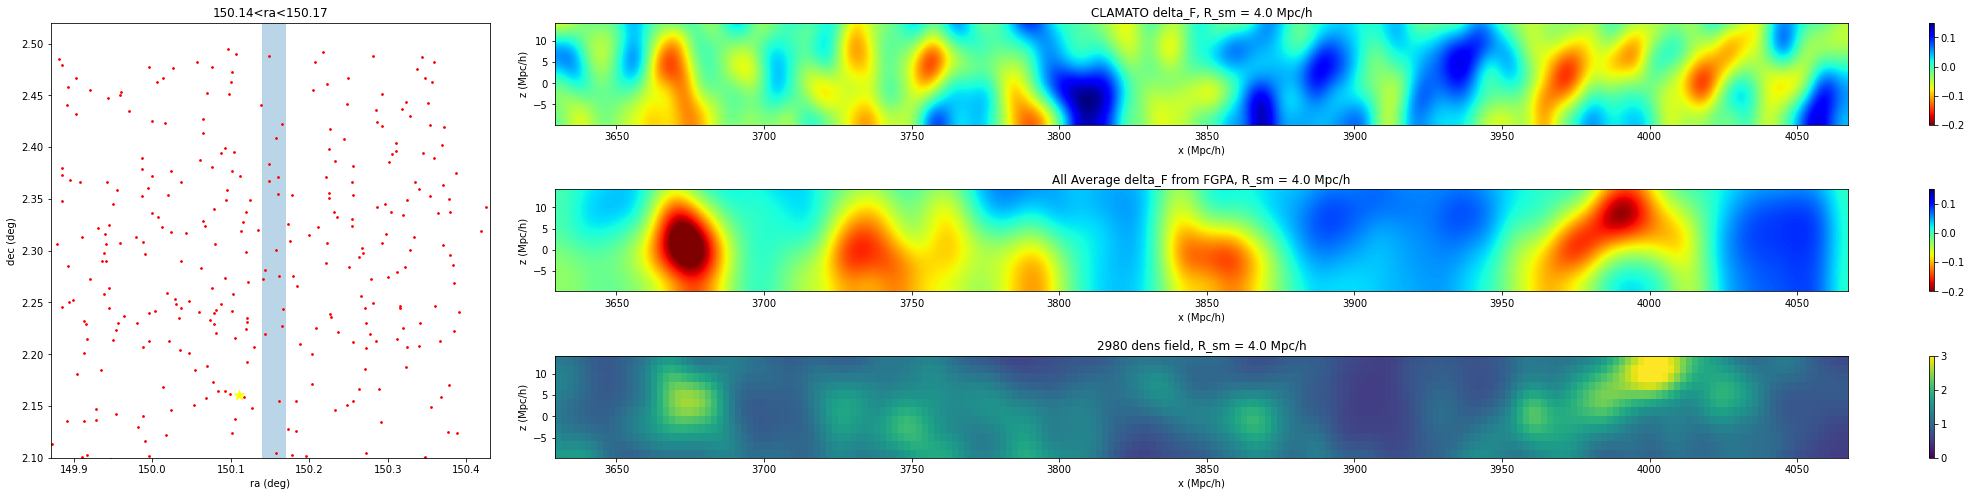

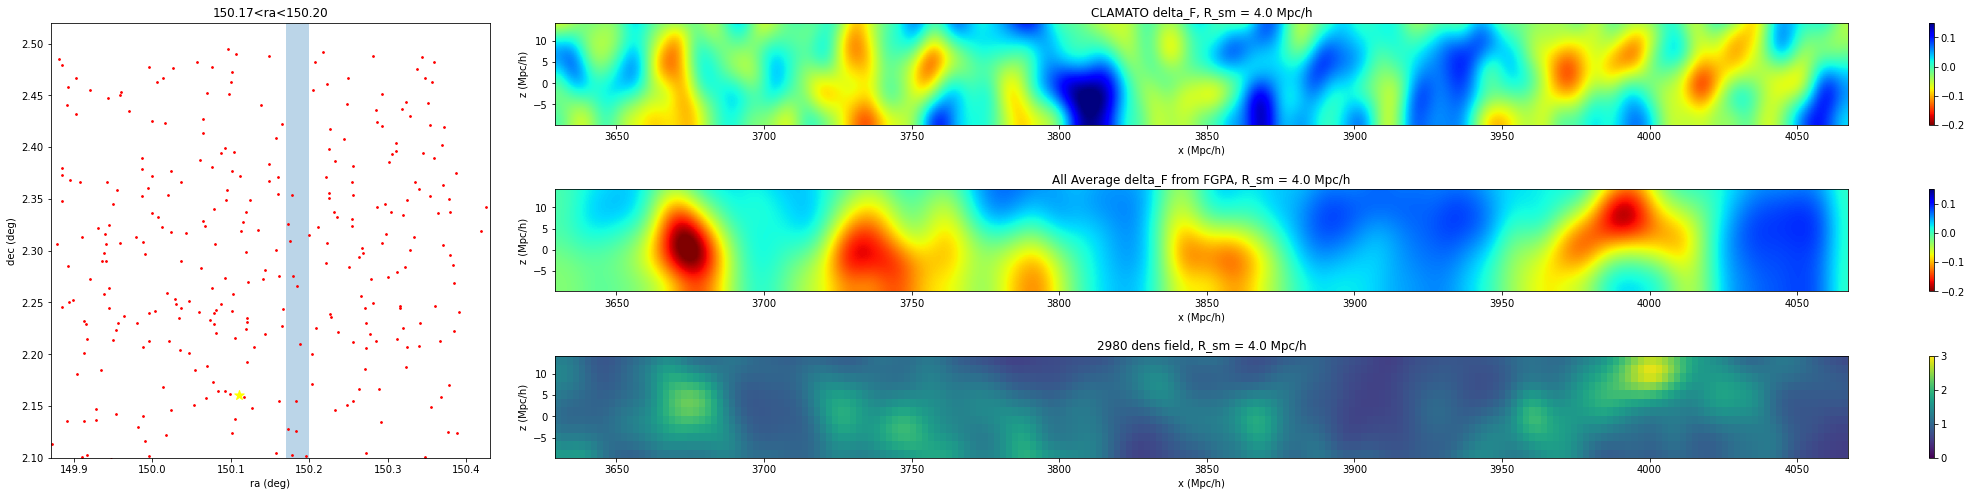

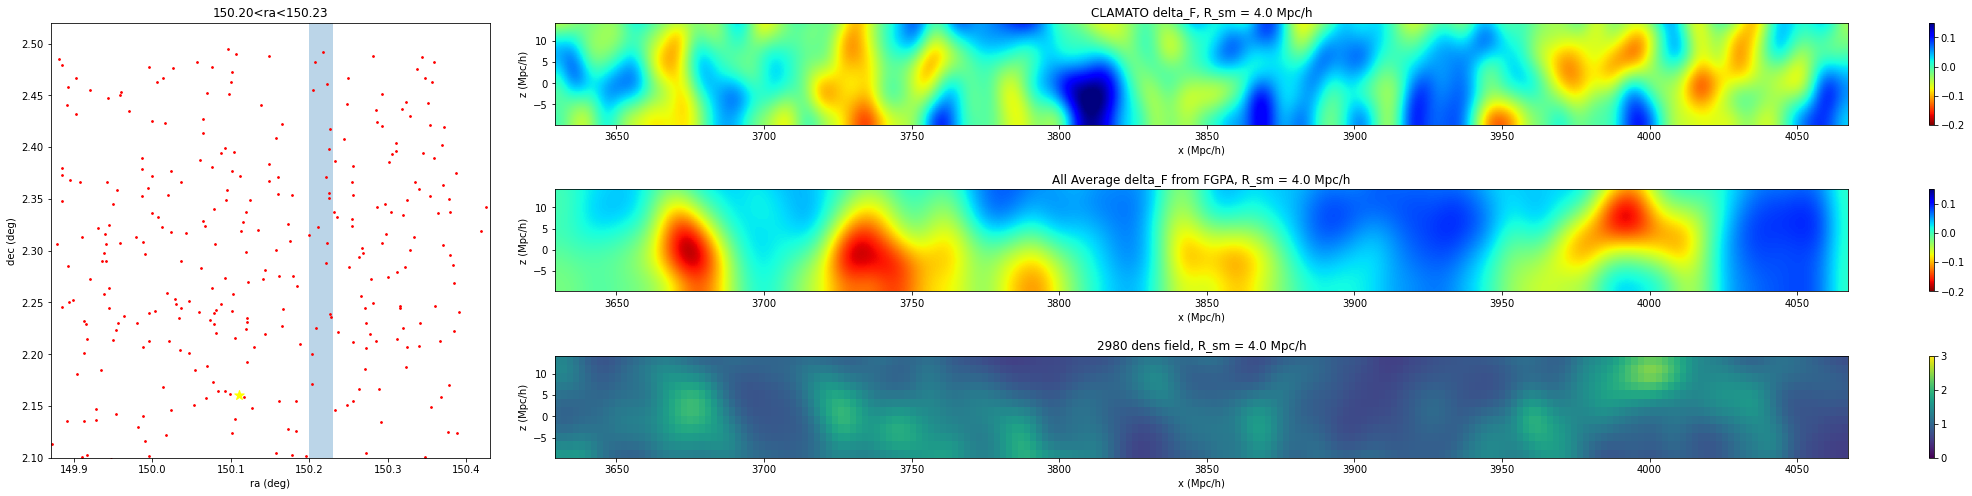

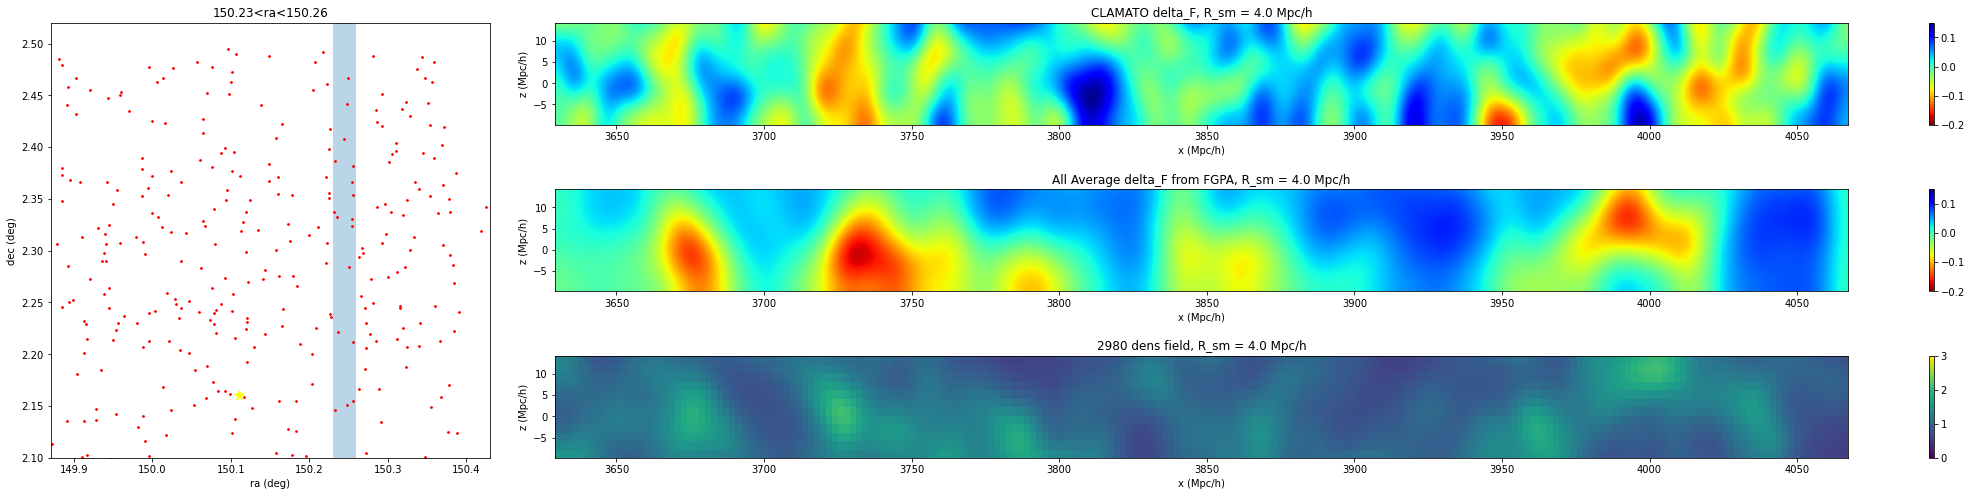

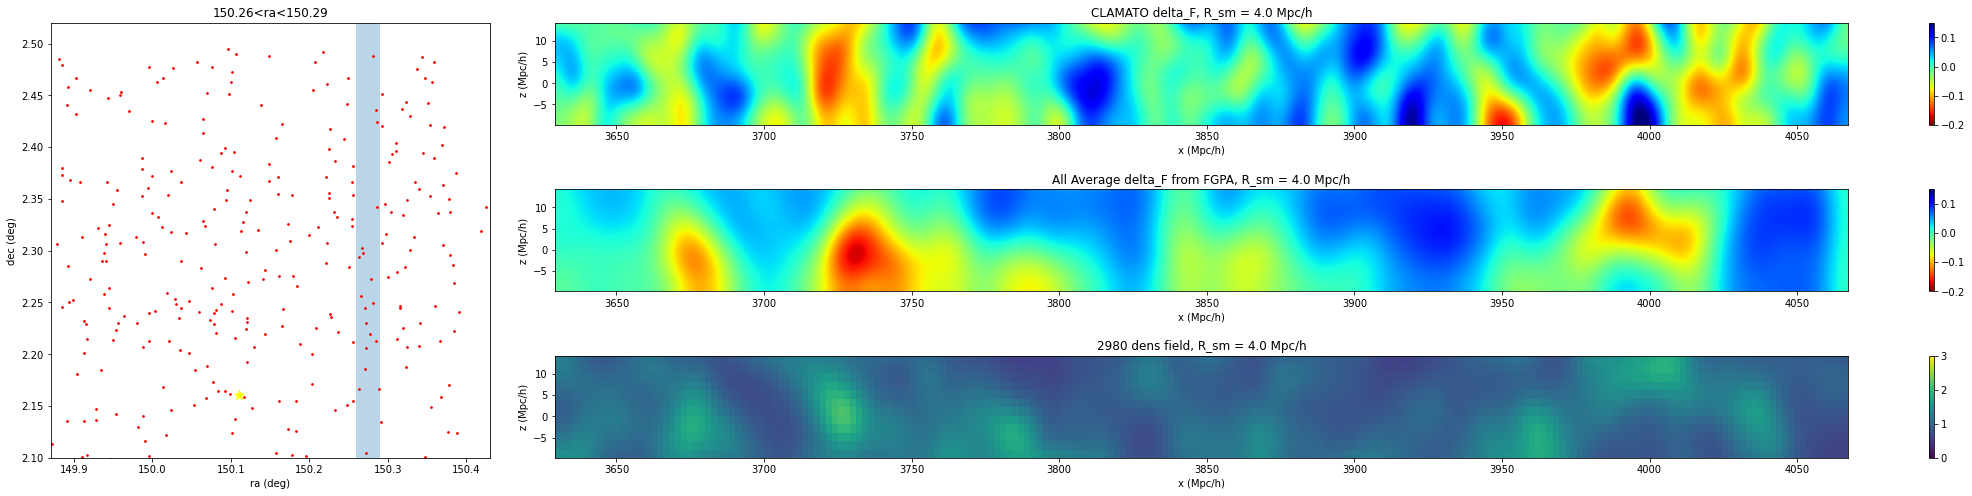

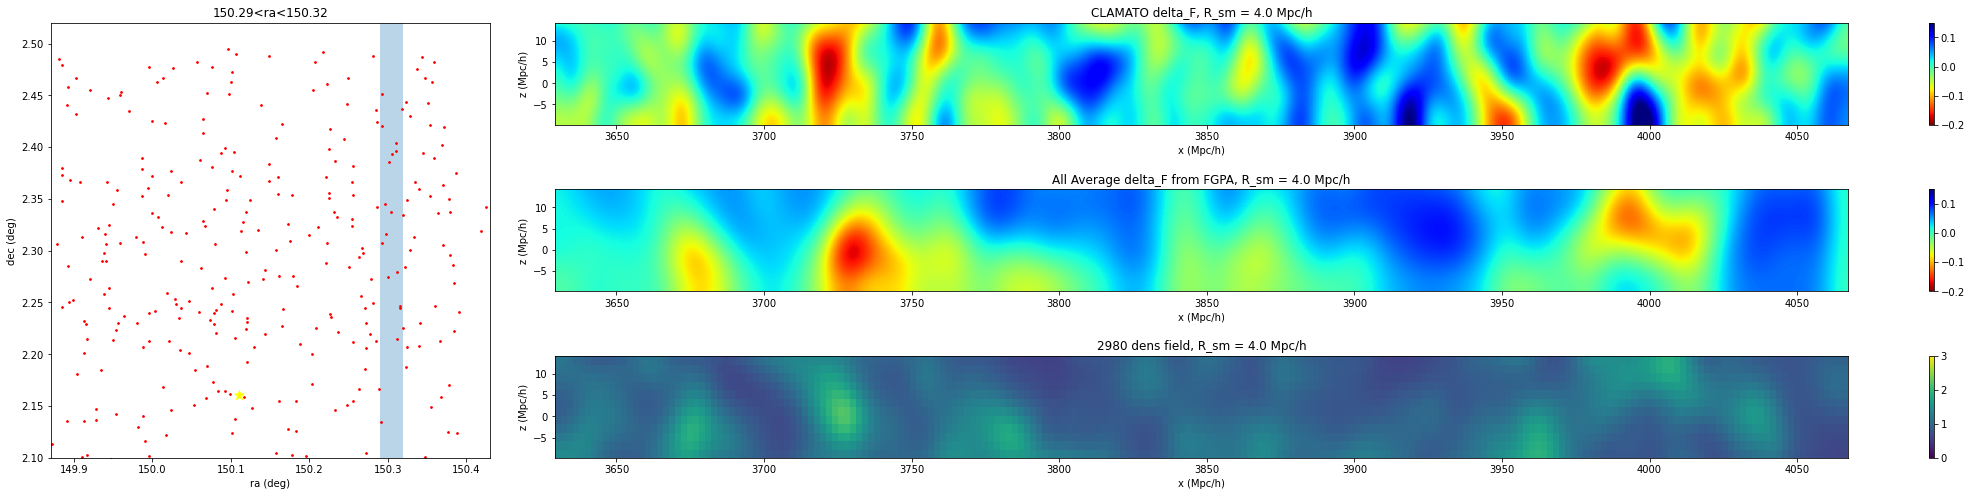

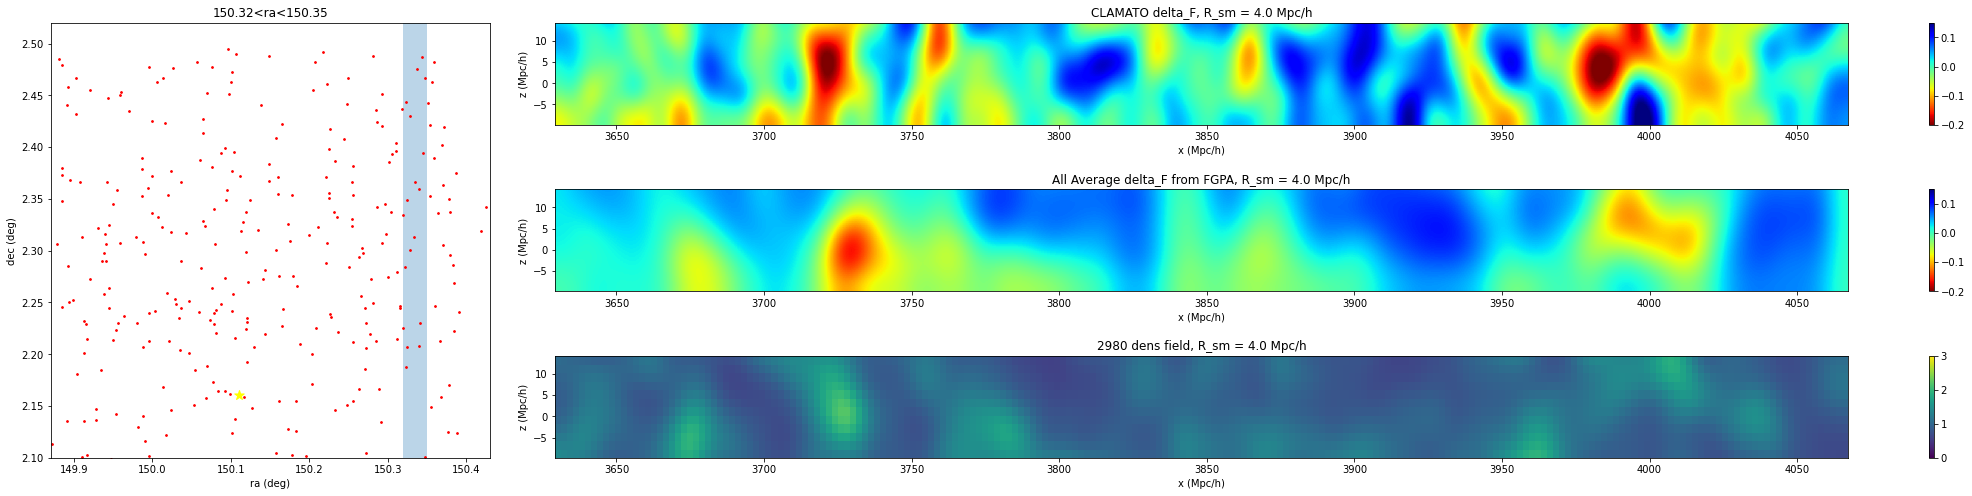

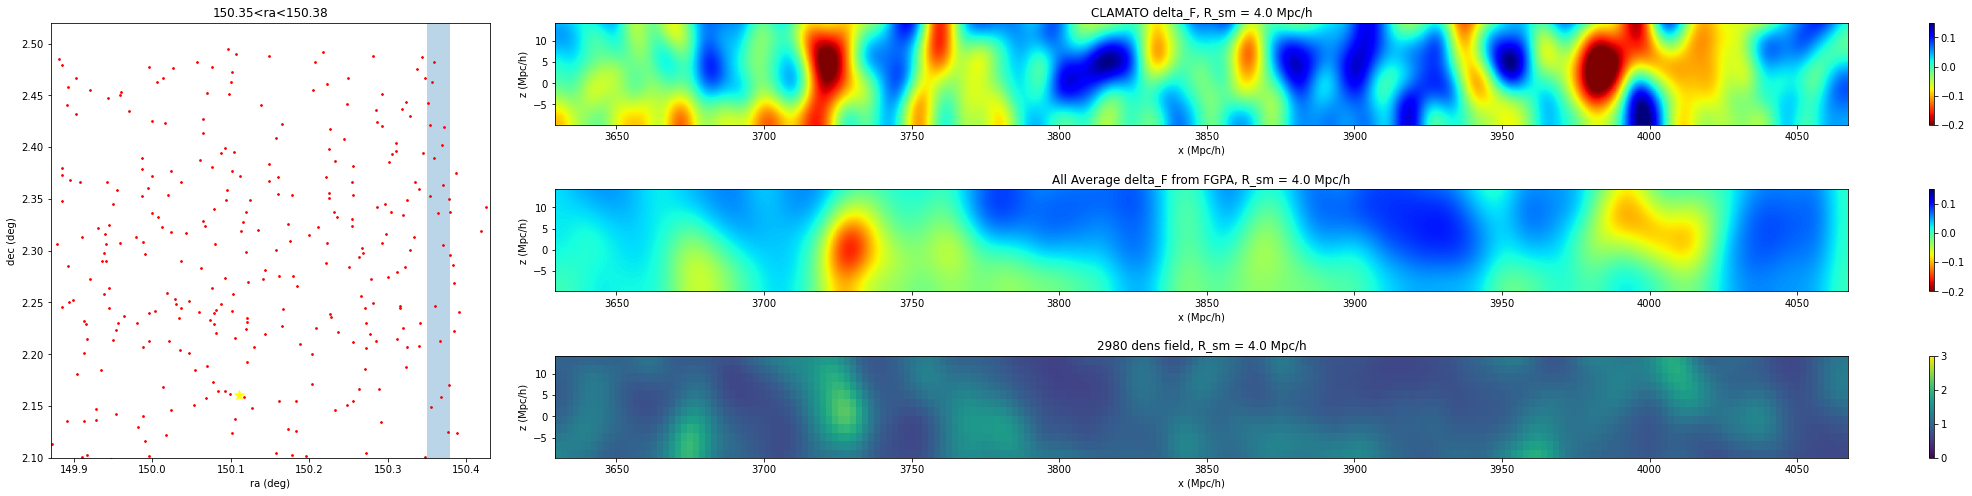

In [17]:
# save as pdf
sim_name = 'All Average'
assert R_sm == 4 * u.Mpc

pdf_pages = PdfPages('sliceplots_Void_All_average_4Mpc.pdf')


for ra_min in np.arange(149.90, 150.371, 0.03):
    ra_max = ra_min + 0.03
    
    fig = plt.figure(figsize = (38, 8))
    grid = plt.GridSpec(8, 38)
    
    
    plt.subplot(grid[0:8, 0:8])
    plt.title('{:.2f}<ra<{:.2f}'.format(ra_min, ra_max))
    ax = plt.gca()
    ax.add_patch(patches.Rectangle([ra_min, 2.05], ra_max-ra_min, 0.5, alpha = 0.3))
    plt.scatter(clm_gal_list['ra'], clm_gal_list['dec'], c = 'red', s = 3)
    plt.scatter(RA, DE, s = 100, marker = '*',  c = 'yellow')
    plt.xlim(149.87, 150.43)
    plt.ylim(2.10, 2.52)
    plt.xlabel('ra (deg)')
    plt.ylabel('dec (deg)')
    
    plt.subplot(grid[0:2, 9:38])
    plt.title('CLAMATO delta_F, R_sm = {}/h'.format(R_sm))
    _, y_min, _ = mycoord.orig_to_box(ra_max, dec_mean, red_mean) # Note y axis is reversed
    _, y_max, _ = mycoord.orig_to_box(ra_min, dec_mean, red_mean) # Note y axis is reversed
    field = CLAMATO_field.clip_with_coord([x_min, y_min, z_min], [x_max, y_max, z_max])


    
    # tracers # toggle this off for better output
    # pix_df_slice = pixel_data_df[(pixel_data_df['y'] > y_min.value) & (pixel_data_df['y'] < y_max.value)]
    # plt.scatter(pix_df_slice['x'], pix_df_slice['z'], s = 3, c = pix_df_slice['delta_f'], cmap='jet_r', vmin=-0.3, vmax=0.2)
    
    # field
    plt.imshow(field.field_data.mean(axis=1).T, origin='lower', 
               extent = [x_min.value, x_max.value, z_min.value, z_max.value], 
               cmap='jet_r', vmin=-0.2, vmax=0.15) # modified this
    plt.axis('auto')
    plt.xlabel('x (Mpc/h)')
    plt.ylabel('z (Mpc/h)')
    plt.xlim(x_min.value, x_max.value)
    plt.ylim(z_min.value, z_max.value)
    plt.colorbar()
    if (y_min < y_n) and (y_n < y_max):
        plt.scatter(x_n, z_n, s = 100, marker = '*',  c = 'yellow')
    

    plt.subplot(grid[3:5, 9:38])
    plt.title('{} delta_F from FGPA, R_sm = {}/h'.format(sim_name, R_sm))
    _, y_min, _ = mycoord.orig_to_box(ra_max, dec_mean, red_mean) # Note y axis is reversed
    _, y_max, _ = mycoord.orig_to_box(ra_min, dec_mean, red_mean) # Note y axis is reversed
    field = rec_field.clip_with_coord([x_min, y_min, z_min], [x_max, y_max, z_max])
    plt.imshow(field.field_data.mean(axis=1).T, origin='lower', 
               extent = [x_min.value, x_max.value, z_min.value, z_max.value], 
               cmap='jet_r', vmin=-0.2, vmax=0.15) # modified this
    plt.axis('auto')
    plt.xlabel('x (Mpc/h)')
    plt.ylabel('z (Mpc/h)')
    plt.xlim(x_min.value, x_max.value)
    plt.ylim(z_min.value, z_max.value)
    plt.colorbar()
    if (y_min < y_n) and (y_n < y_max):
        plt.scatter(x_n, z_n, s = 100, marker = '*',  c = 'yellow')
    
    plt.subplot(grid[6:9, 9:38])
    plt.title('{} dens field, R_sm = {}/h'.format(2980, R_sm))
    _, y_min, _ = mycoord.orig_to_box(ra_max, dec_mean, red_mean) # Note y axis is reversed
    _, y_max, _ = mycoord.orig_to_box(ra_min, dec_mean, red_mean) # Note y axis is reversed
    field = opdelta_m_field.clip_with_coord([x_min, y_min, z_min], [x_max, y_max, z_max])
    plt.imshow(field.field_data.mean(axis=1).T, origin='lower', 
               extent = [x_min.value, x_max.value, z_min.value, z_max.value], 
               vmin=0, vmax=3) # and this
    plt.axis('auto')
    plt.xlabel('x (Mpc/h)')
    plt.ylabel('z (Mpc/h)')
    plt.xlim(x_min.value, x_max.value)
    plt.ylim(z_min.value, z_max.value)
    plt.colorbar()
    if (y_min < y_n) and (y_n < y_max):
        plt.scatter(x_n, z_n, s = 100, marker = '*', c = 'yellow')

    #plt.show()
    pdf_pages.savefig(fig)

pdf_pages.close()

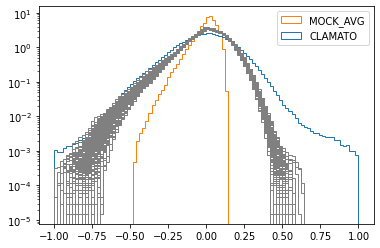

In [7]:
# plt.hist(, density = True, range = (-1, 1), histtype='step', color = )
plt.hist([delta_clm.flatten(), delta_rec_mock.flatten()], density = True, range = (-1, 1), histtype='step', label = ['CLAMATO', 'MOCK_AVG'], bins = 100)
[plt.hist(field_data.flatten(), density = True, range = (-1, 1), histtype='step',  color = 'grey', bins = 100) for field_data in delta_mock_list]
plt.yscale('log')
plt.legend()

In [10]:
delta_rec = np.fromfile("../Data/rec_field_hires/pixel_data_tau.npy_0_true_SNR.bin_map.bin", dtype='double').reshape(68, 56, 876).transpose(2, 0, 1)
delta_rec = delta_rec[::1,::-1,::1]
# this reversal is due to the coordinate in clamato is 
#    x - ra     y - dec
#    0 - 149.89 0 - 2.07
#    68 - 150.4 56 - 2.50  
# consistent with https://github.com/kheegan/preheating2019
x_0, y_0, z_0 = mycoord.orig_to_box(149.89, 2.07, 2.05)
rec_field = Field(x_0, y_0-34*u.Mpc, z_0, 0.5*u.Mpc, delta_rec)
res = rec_field.smooth(R_sm)

In [13]:
dens_hires = np.load("../Data/dens_1024_central_cic.npy")[::1,::-1,::1]
F = Field(3550.*u.Mpc, -50.*u.Mpc, -50.*u.Mpc, 0.5*u.Mpc, dens_hires)
res = F.smooth(R_sm)

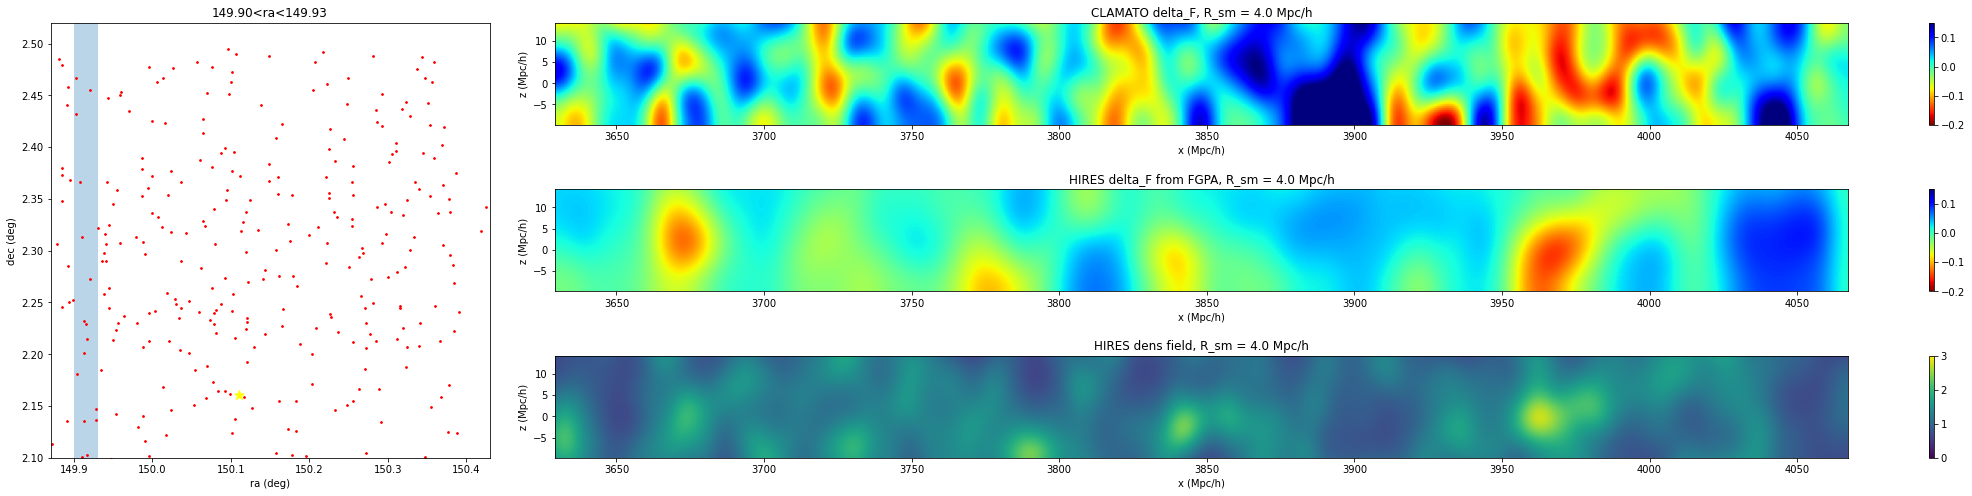

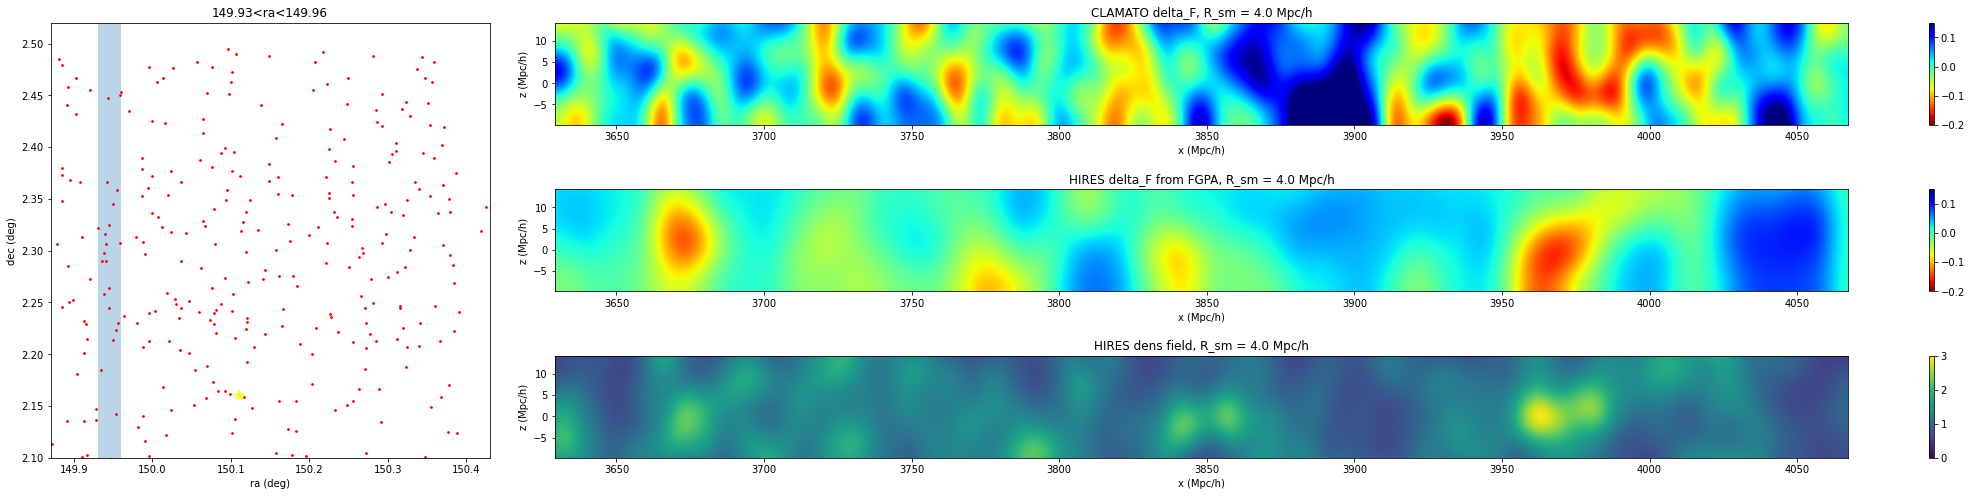

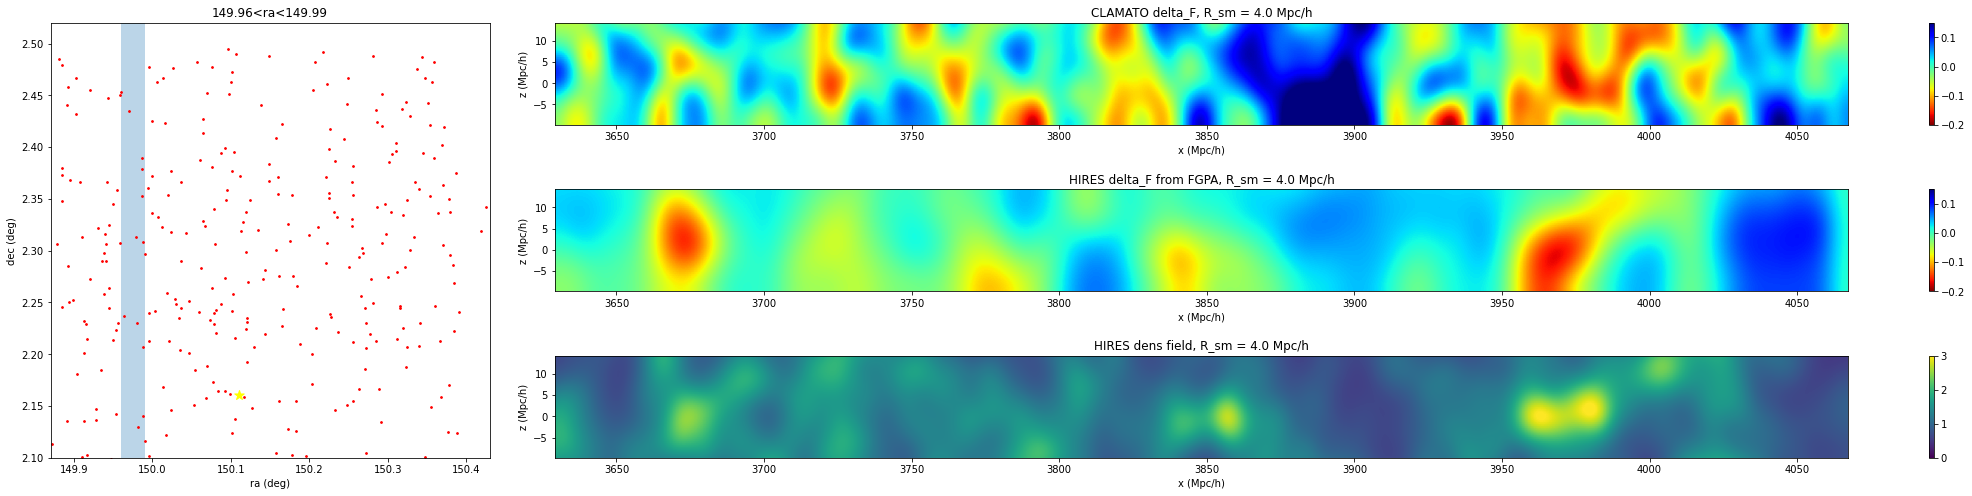

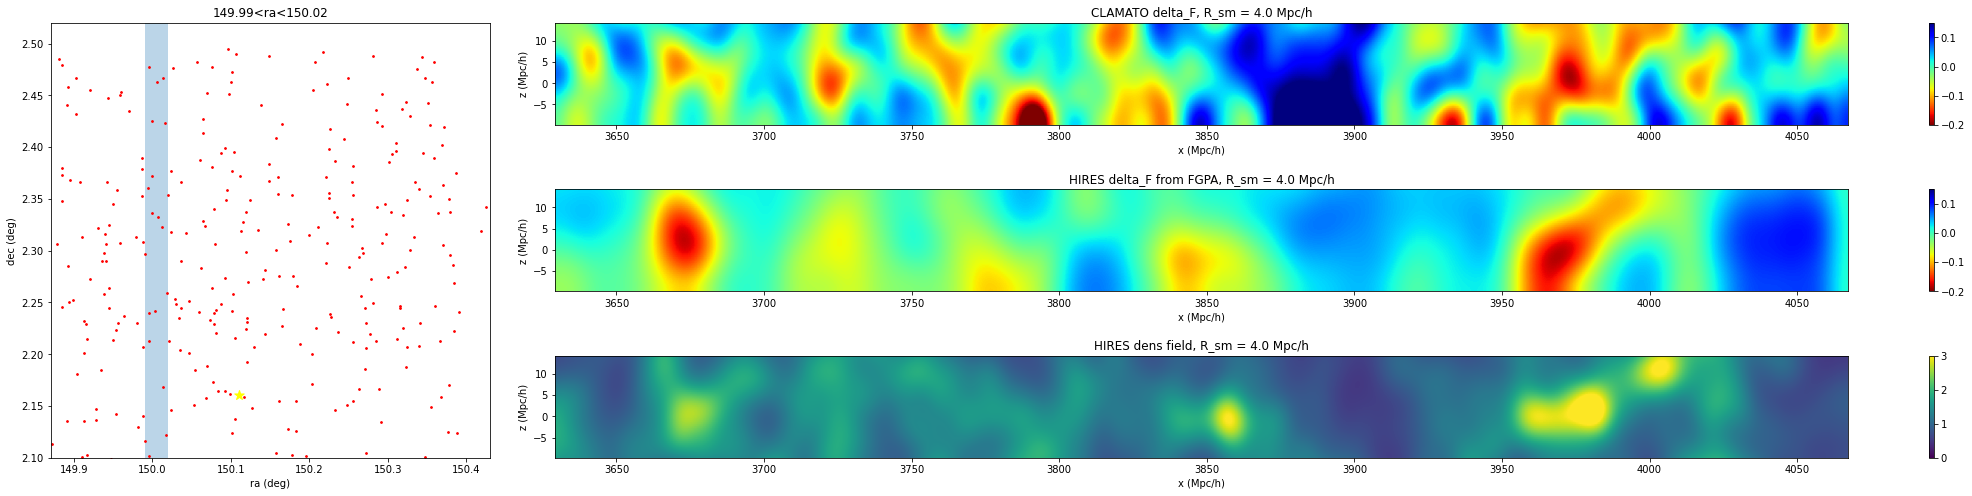

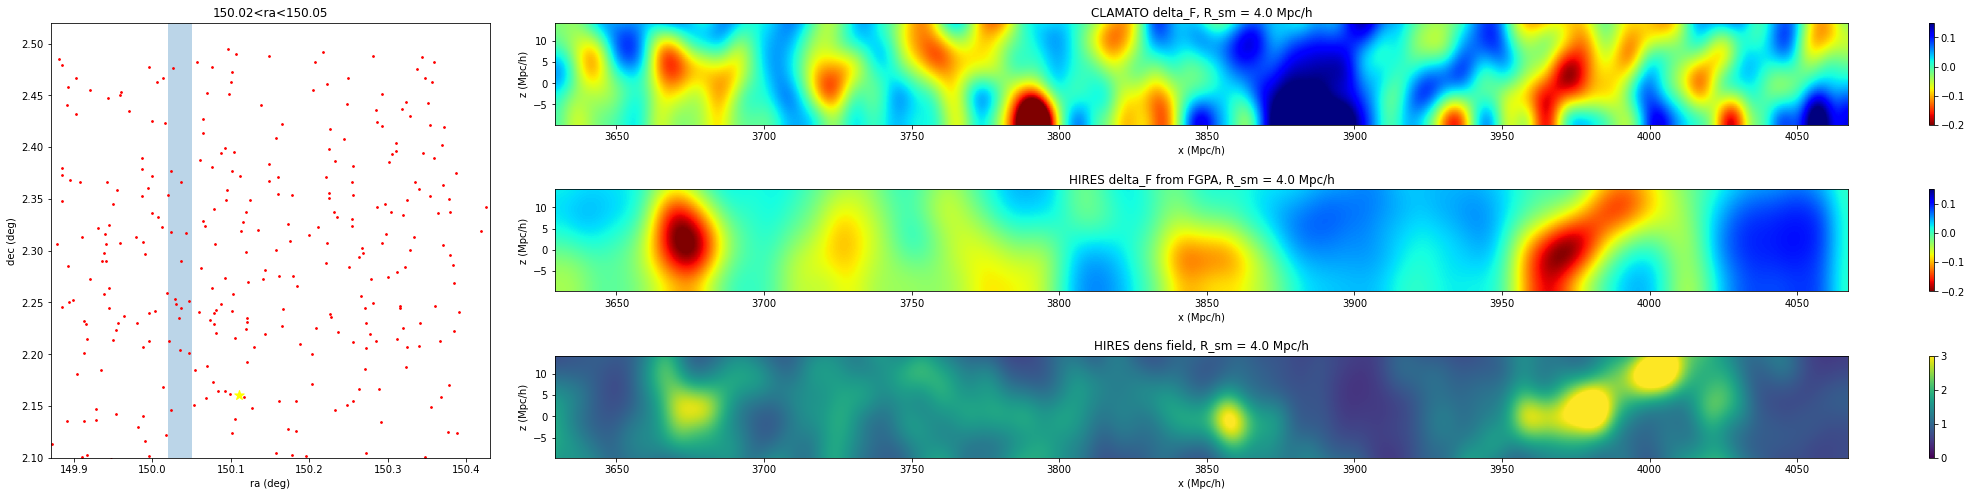

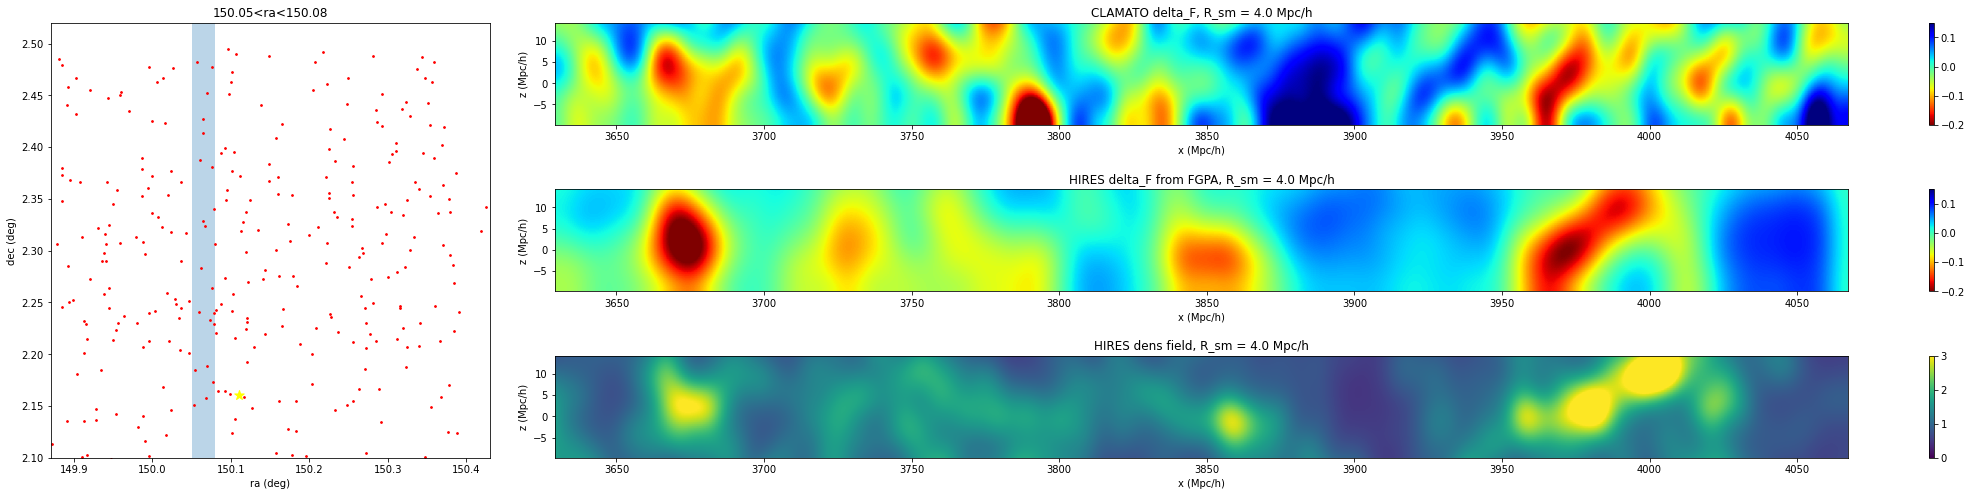

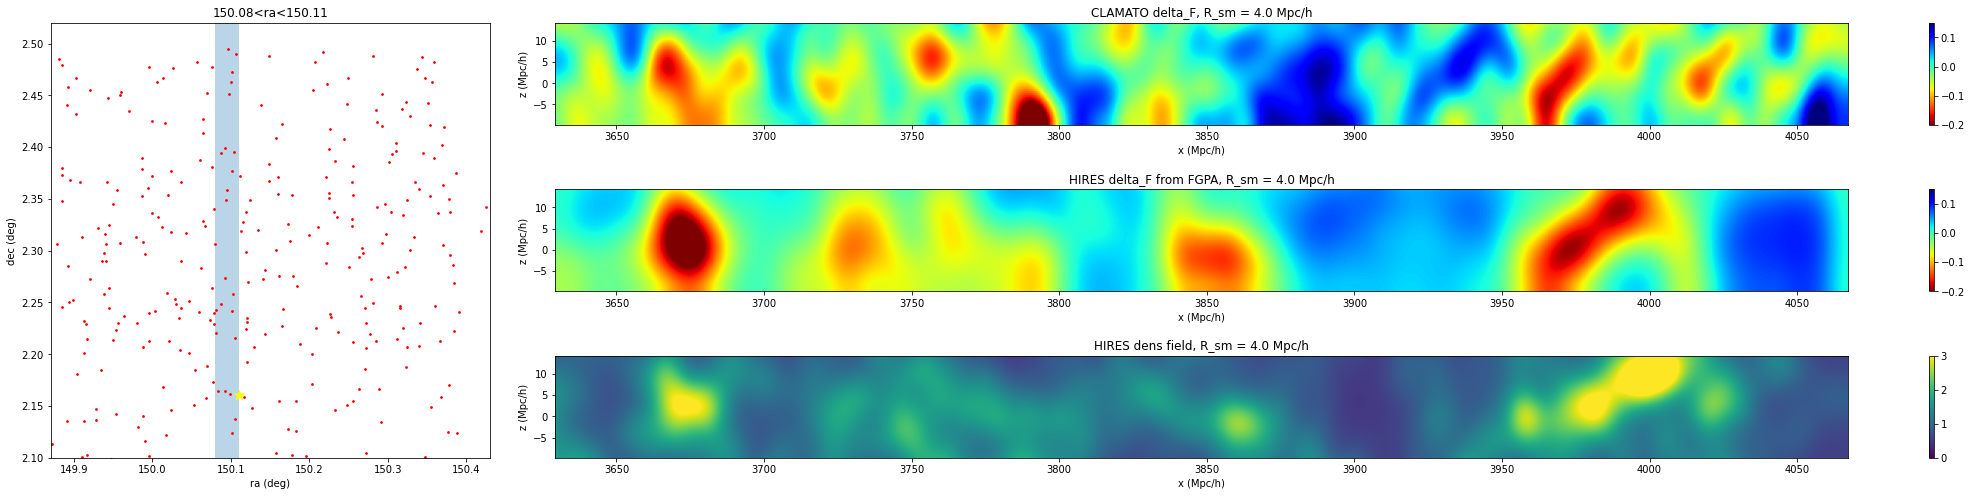

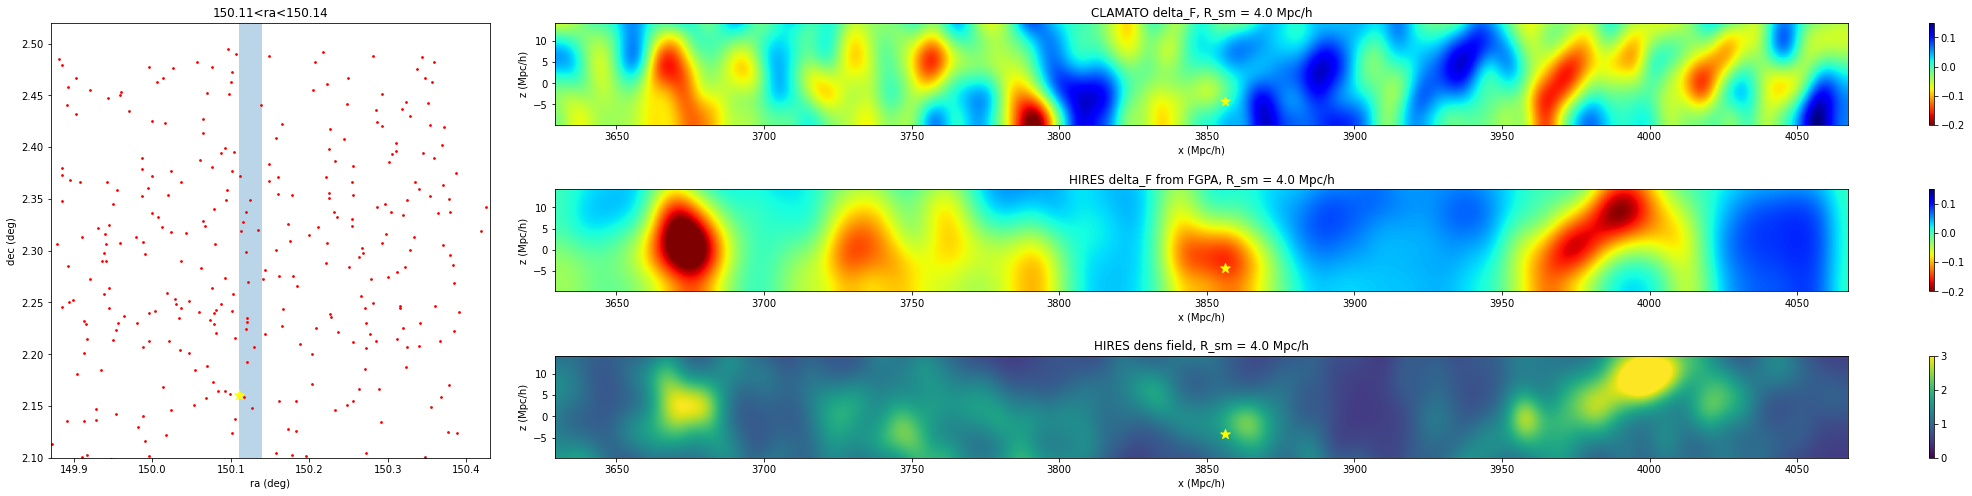

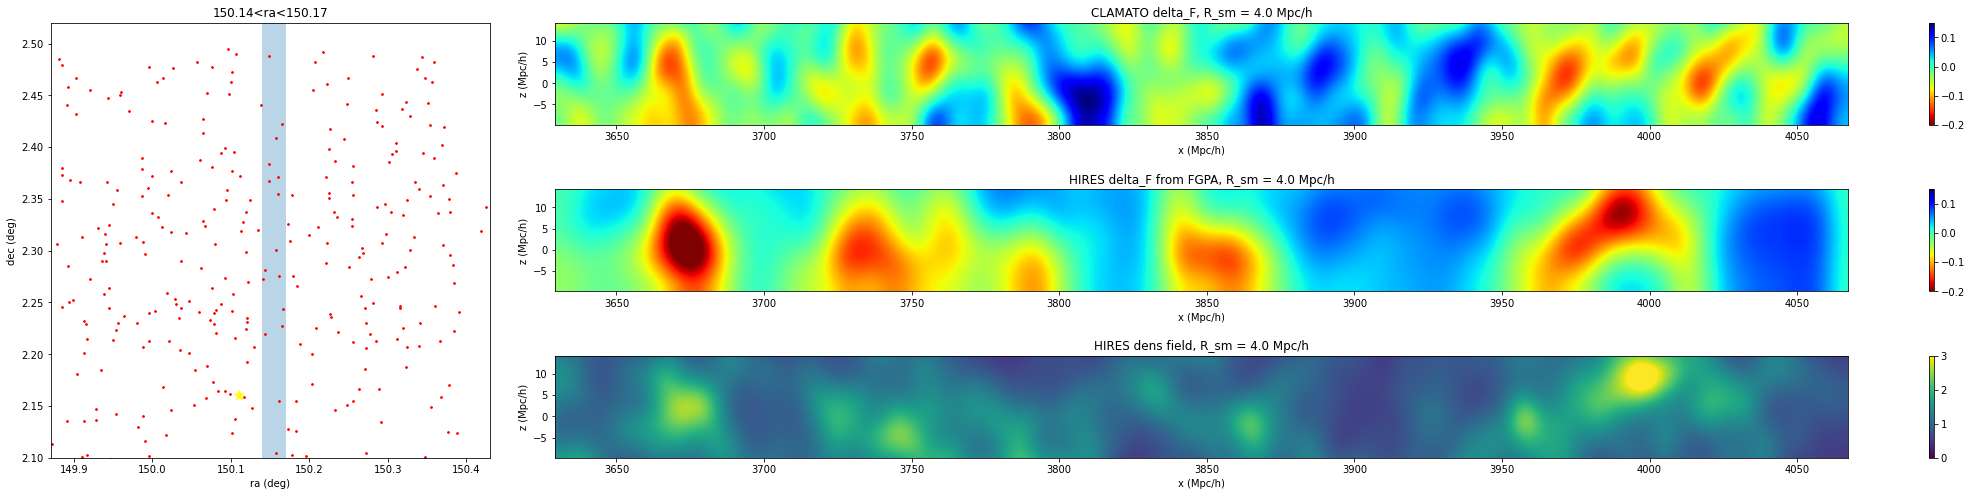

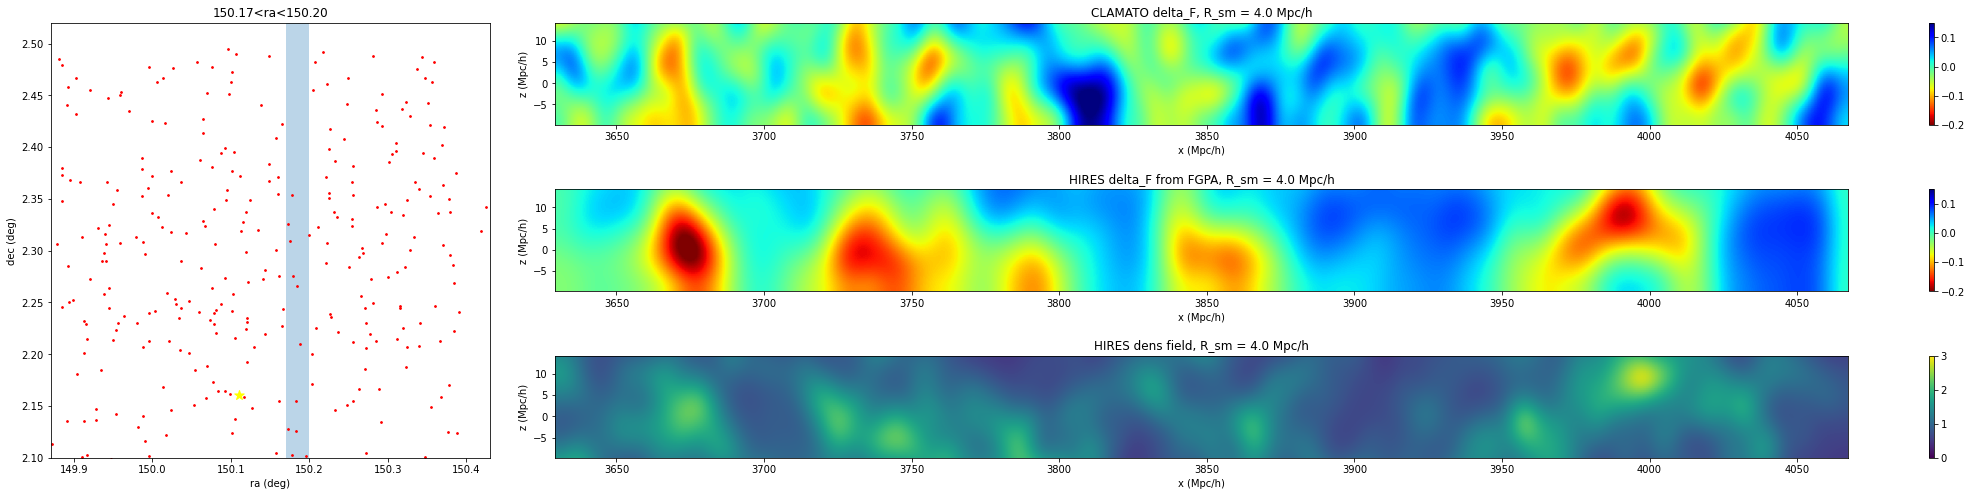

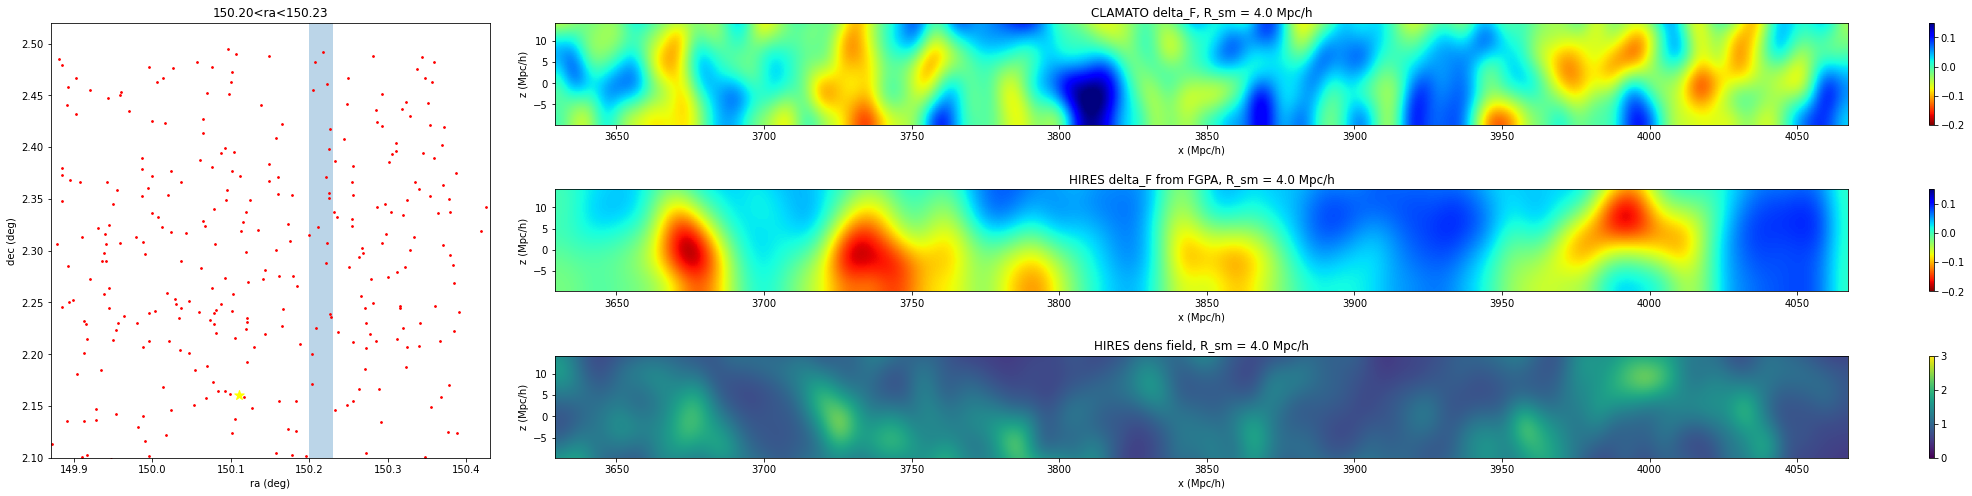

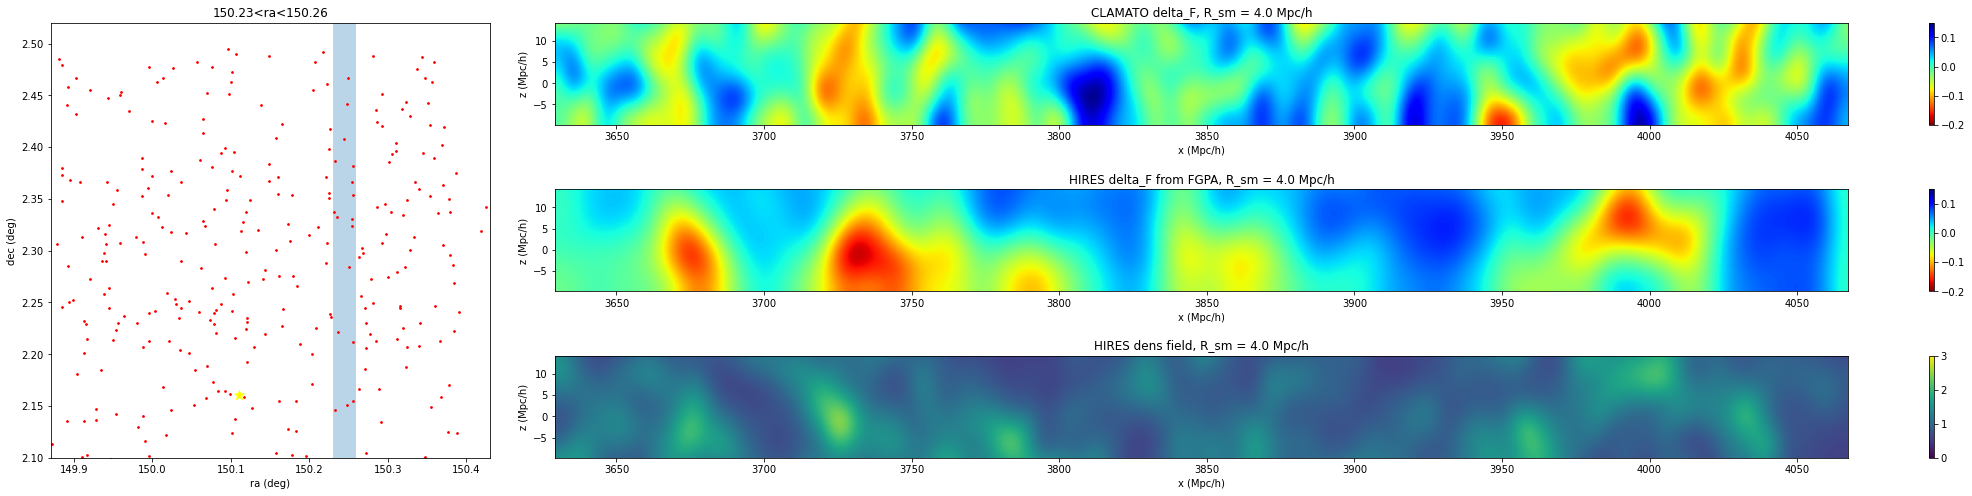

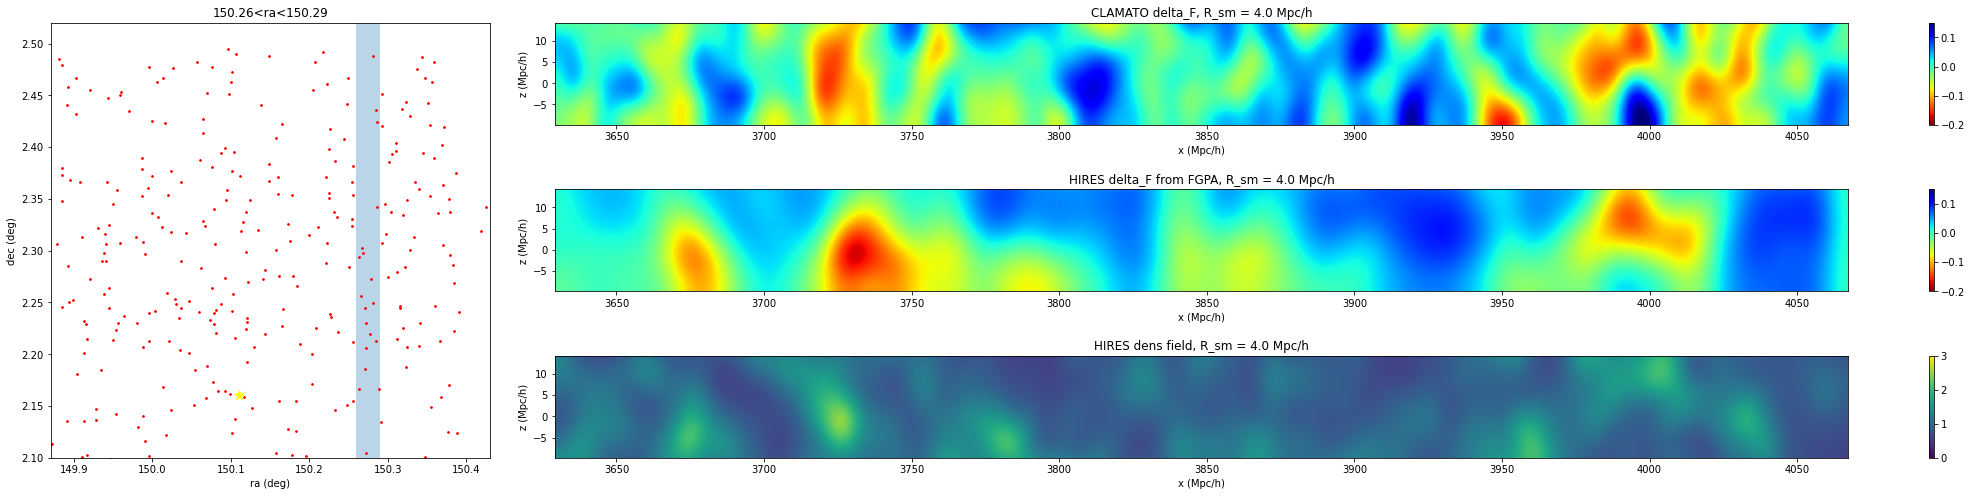

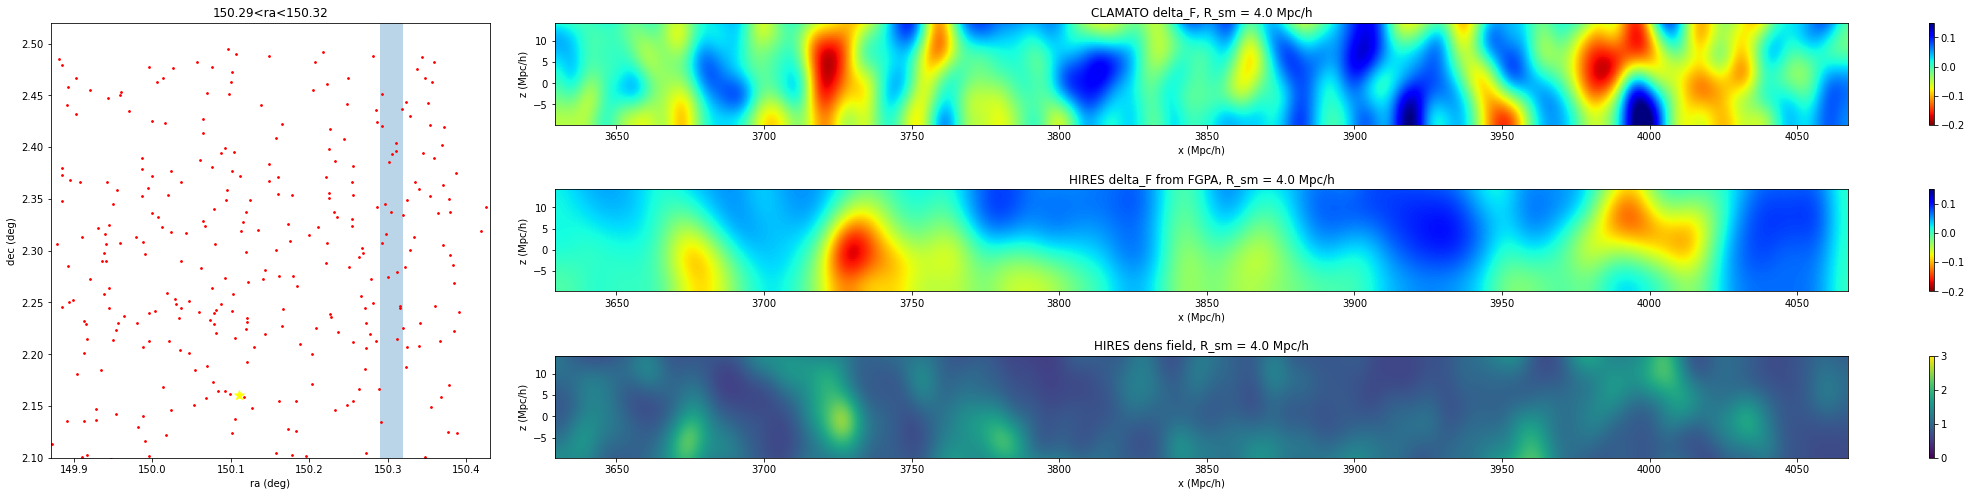

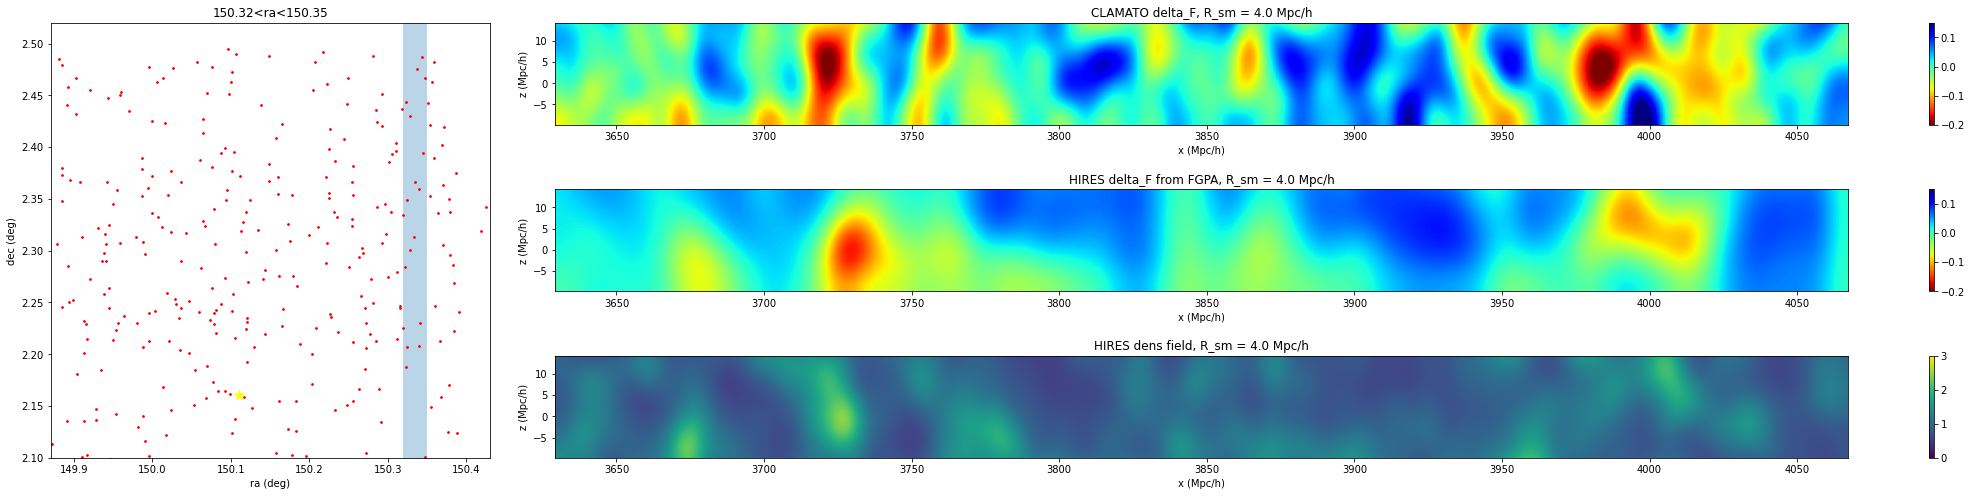

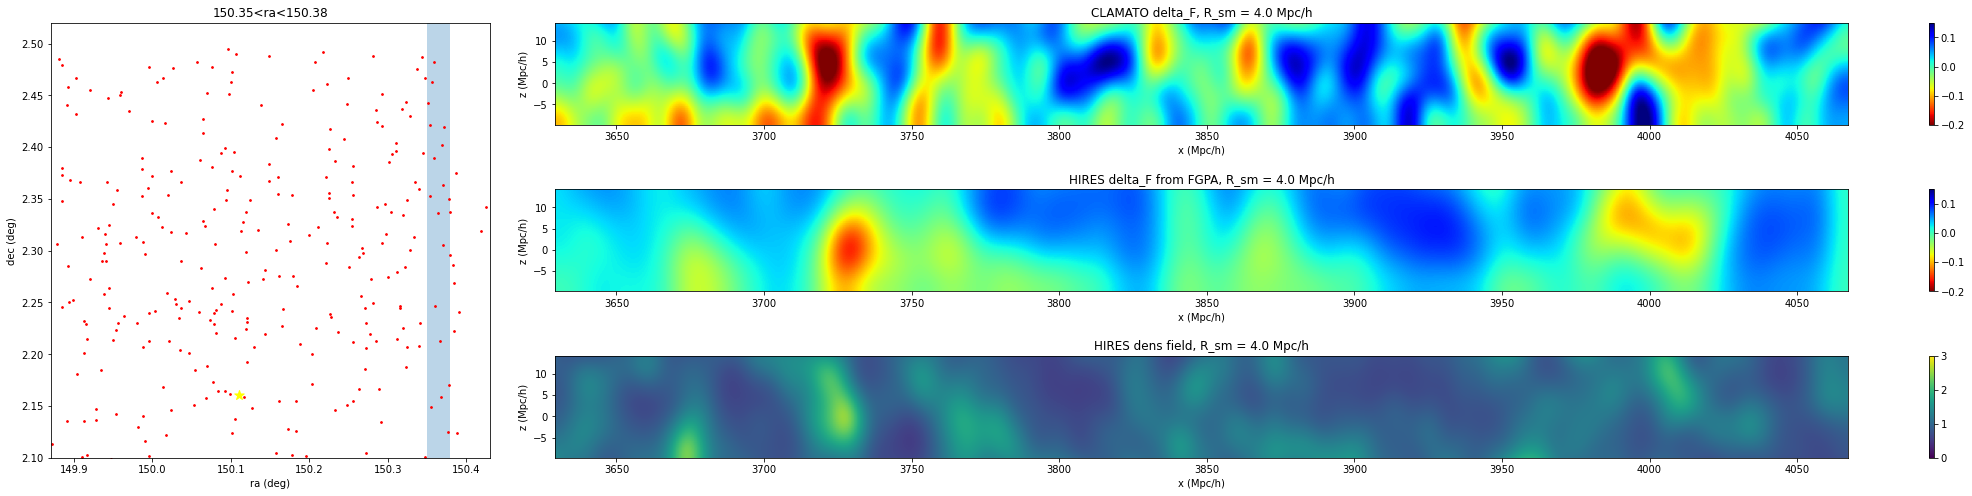

In [21]:
# save as pdf
sim_name = 'HIRES'
assert R_sm == 4 * u.Mpc

pdf_pages = PdfPages('sliceplots_HIRES.pdf')



for ra_min in np.arange(149.90, 150.371, 0.03):
    ra_max = ra_min + 0.03
    
    fig = plt.figure(figsize = (38, 8))
    grid = plt.GridSpec(8, 38)
    
    
    plt.subplot(grid[0:8, 0:8])
    plt.title('{:.2f}<ra<{:.2f}'.format(ra_min, ra_max))
    ax = plt.gca()
    ax.add_patch(patches.Rectangle([ra_min, 2.05], ra_max-ra_min, 0.5, alpha = 0.3))
    plt.scatter(clm_gal_list['ra'], clm_gal_list['dec'], c = 'red', s = 3)
    plt.scatter(RA, DE, s = 100, marker = '*',  c = 'yellow')
    plt.xlim(149.87, 150.43)
    plt.ylim(2.10, 2.52)
    plt.xlabel('ra (deg)')
    plt.ylabel('dec (deg)')
    
    plt.subplot(grid[0:2, 9:38])
    plt.title('CLAMATO delta_F, R_sm = {}/h'.format(R_sm))
    _, y_min, _ = mycoord.orig_to_box(ra_max, dec_mean, red_mean) # Note y axis is reversed
    _, y_max, _ = mycoord.orig_to_box(ra_min, dec_mean, red_mean) # Note y axis is reversed
    field = CLAMATO_field.clip_with_coord([x_min, y_min, z_min], [x_max, y_max, z_max])


    
    # tracers # toggle this off for better output
    # pix_df_slice = pixel_data_df[(pixel_data_df['y'] > y_min.value) & (pixel_data_df['y'] < y_max.value)]
    # plt.scatter(pix_df_slice['x'], pix_df_slice['z'], s = 3, c = pix_df_slice['delta_f'], cmap='jet_r', vmin=-0.3, vmax=0.2)
    
    # field
    plt.imshow(field.field_data.mean(axis=1).T, origin='lower', 
               extent = [x_min.value, x_max.value, z_min.value, z_max.value], 
               cmap='jet_r', vmin=-0.2, vmax=0.15) # modified this
    plt.axis('auto')
    plt.xlabel('x (Mpc/h)')
    plt.ylabel('z (Mpc/h)')
    plt.xlim(x_min.value, x_max.value)
    plt.ylim(z_min.value, z_max.value)
    plt.colorbar()
    if (y_min < y_n) and (y_n < y_max):
        plt.scatter(x_n, z_n, s = 100, marker = '*',  c = 'yellow')
    

    plt.subplot(grid[3:5, 9:38])
    plt.title('{} delta_F from FGPA, R_sm = {}/h'.format(sim_name, R_sm))
    _, y_min, _ = mycoord.orig_to_box(ra_max, dec_mean, red_mean) # Note y axis is reversed
    _, y_max, _ = mycoord.orig_to_box(ra_min, dec_mean, red_mean) # Note y axis is reversed
    field = rec_field.clip_with_coord([x_min, y_min, z_min], [x_max, y_max, z_max])
    plt.imshow(field.field_data.mean(axis=1).T, origin='lower', 
               extent = [x_min.value, x_max.value, z_min.value, z_max.value], 
               cmap='jet_r', vmin=-0.2, vmax=0.15) # modified this
    plt.axis('auto')
    plt.xlabel('x (Mpc/h)')
    plt.ylabel('z (Mpc/h)')
    plt.xlim(x_min.value, x_max.value)
    plt.ylim(z_min.value, z_max.value)
    plt.colorbar()
    if (y_min < y_n) and (y_n < y_max):
        plt.scatter(x_n, z_n, s = 100, marker = '*',  c = 'yellow')
    
    plt.subplot(grid[6:9, 9:38])
    plt.title('{} dens field, R_sm = {}/h'.format("HIRES", R_sm))
    _, y_min, _ = mycoord.orig_to_box(ra_max, dec_mean, red_mean) # Note y axis is reversed
    _, y_max, _ = mycoord.orig_to_box(ra_min, dec_mean, red_mean) # Note y axis is reversed
    field = F.clip_with_coord([x_min, y_min, z_min], [x_max, y_max, z_max])
    plt.imshow(field.field_data.mean(axis=1).T, origin='lower', 
               extent = [x_min.value, x_max.value, z_min.value, z_max.value], 
               vmin=0, vmax=3) # and this
    plt.axis('auto')
    plt.xlabel('x (Mpc/h)')
    plt.ylabel('z (Mpc/h)')
    plt.xlim(x_min.value, x_max.value)
    plt.ylim(z_min.value, z_max.value)
    plt.colorbar()
    if (y_min < y_n) and (y_n < y_max):
        plt.scatter(x_n, z_n, s = 100, marker = '*', c = 'yellow')

    pdf_pages.savefig(fig)

pdf_pages.close()

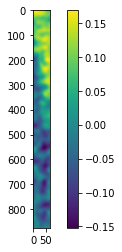

In [43]:
plt.imshow(rec_field.field_data[:,:,10])
plt.colorbar()